In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random


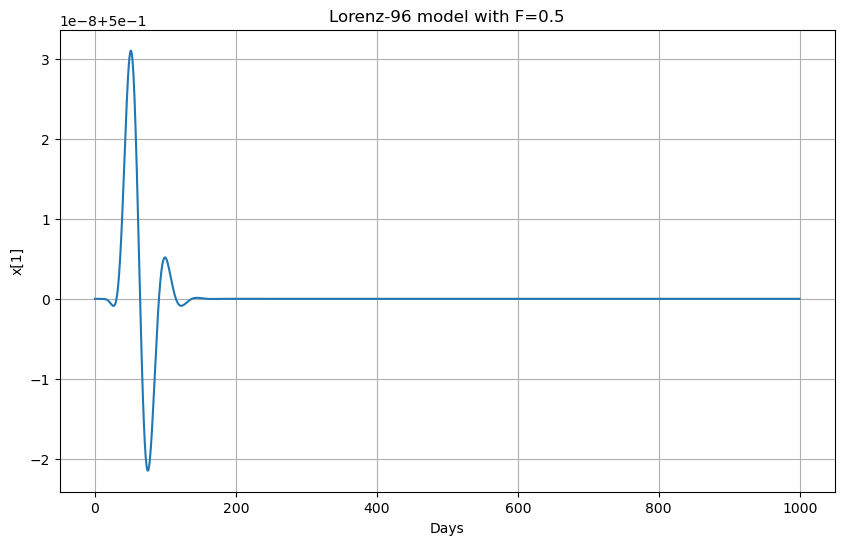

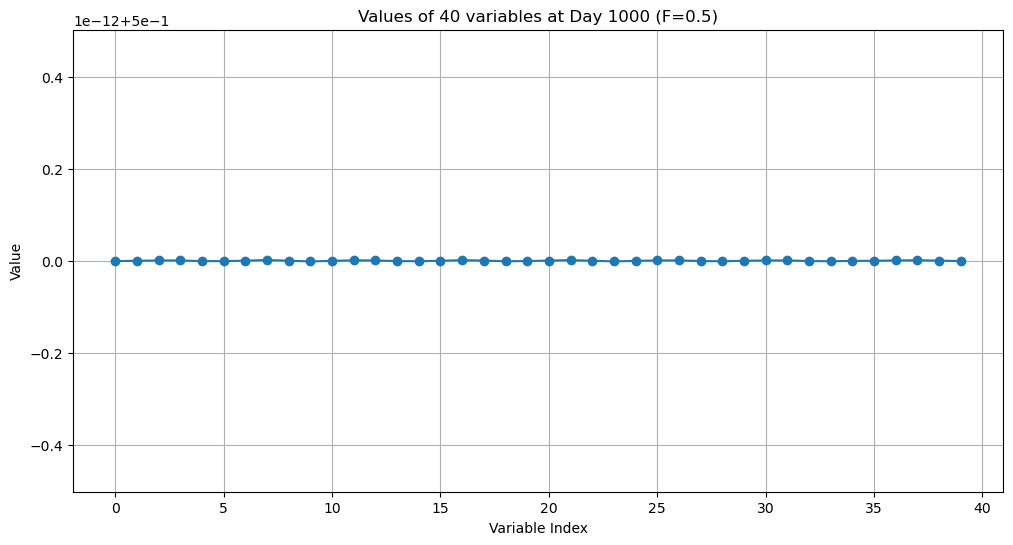

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


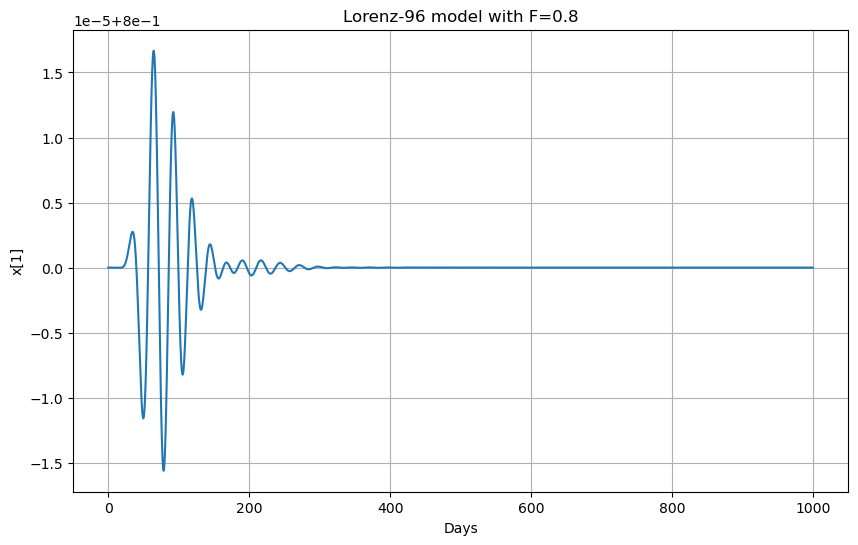

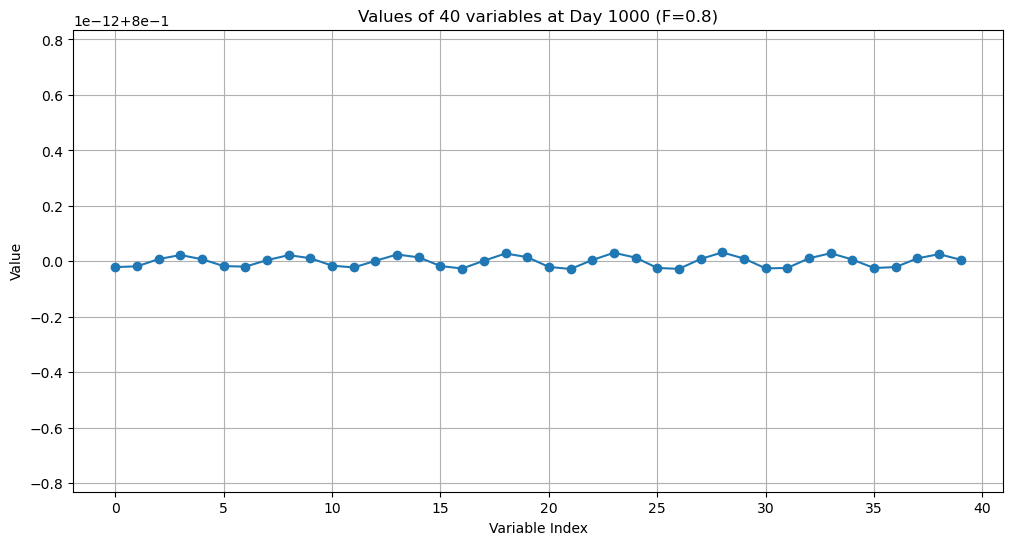

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


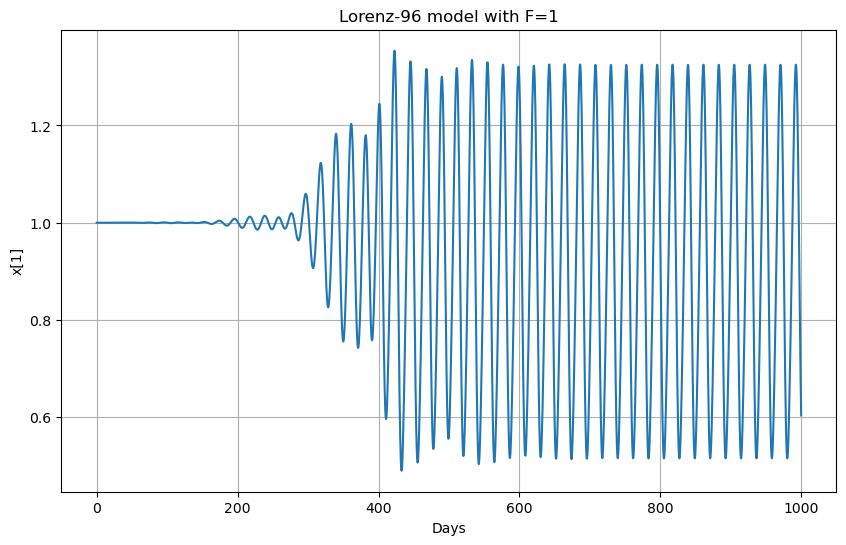

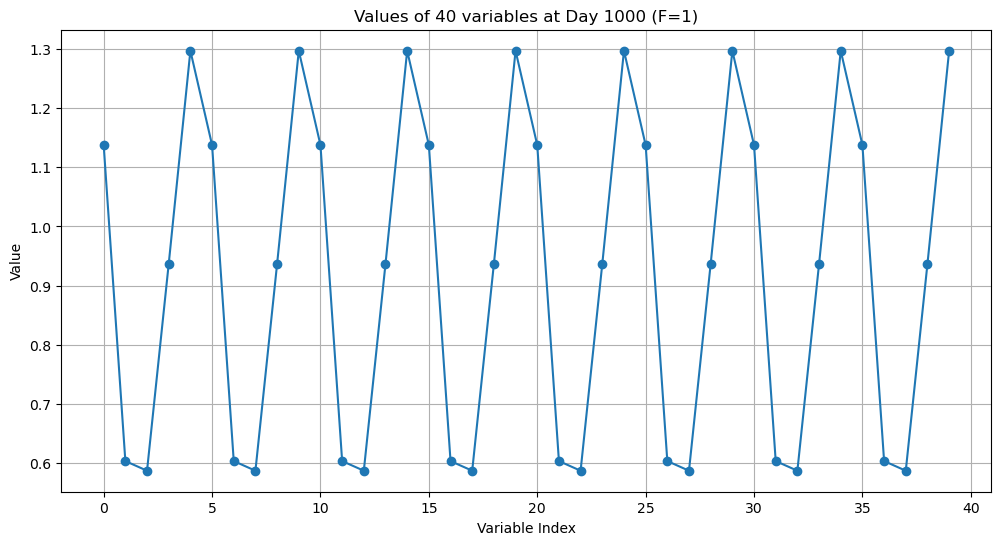

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


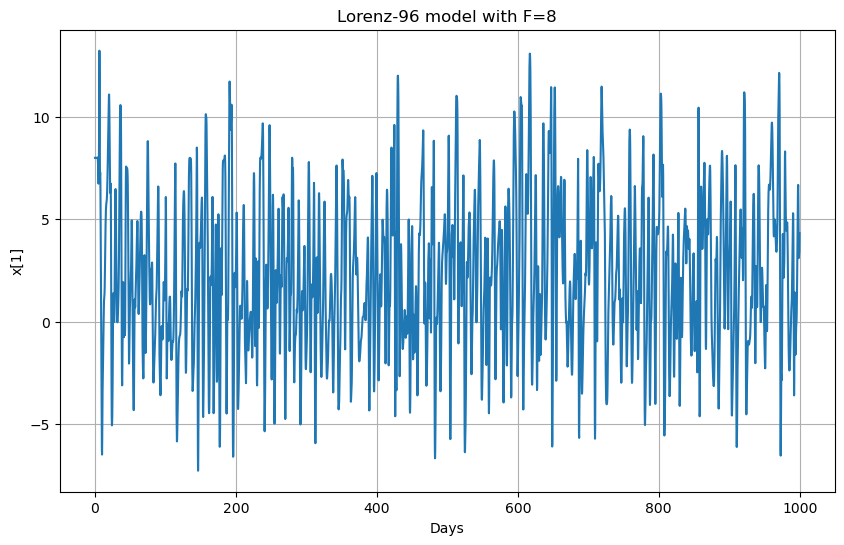

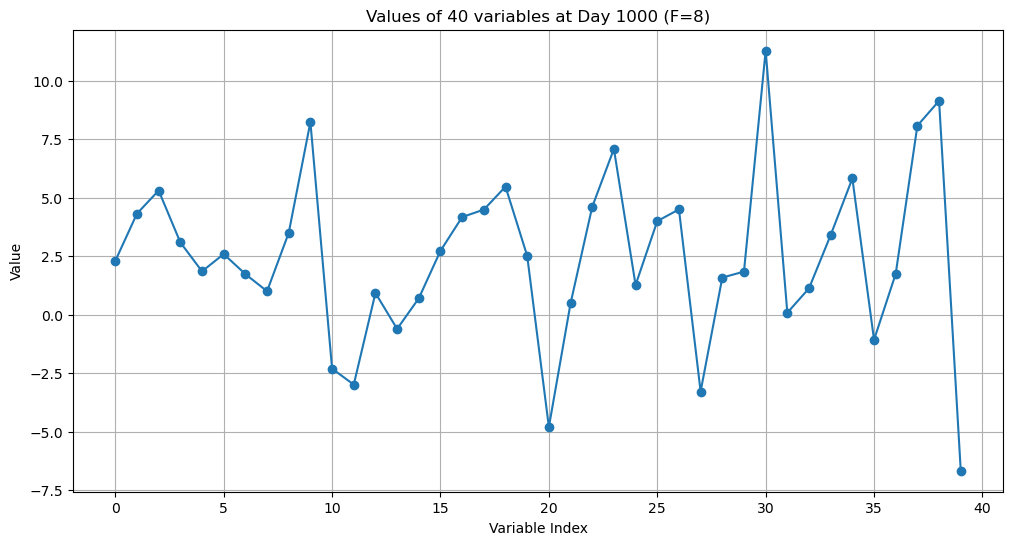

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


In [2]:
"""
１．Lorenz-96 を 4 次の Runge-Kutta 法を用いて実装する。パラメータ値 F をいろいろ変え、
F=8 でカオスとなることを確認する。余裕があれば、他の時間積分スキームも実装してみる。
"""
def lorenz96(x, F):
    """Lorenz 96 model with constant forcing and explicit boundary conditions"""
    N = len(x)
    d = np.zeros(N)
    
    # Main equations for the bulk of the system
    for i in range(2, N - 1):
        d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
    
    # Periodic boundary conditions
    d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
    d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
    d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F
    
    return d

def rk4_step(x, dt=0.05, F=8):
    """4th order Runge-Kutta integration step"""
    k1 = dt * lorenz96(x, F)
    k2 = dt * lorenz96(x + k1 / 2, F)
    k3 = dt * lorenz96(x + k2 / 2, F)
    k4 = dt * lorenz96(x + k3, F)

    return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Parameters
N = 40  # Number of variables
F_values = [0.5,0.8,1,8]  # Different values of F to test
dt = 0.05  # A time step equivalent to 6 hours
Days = 1000  # Total days
steps = Days * 4   # Number of steps

# Time integration
for F in F_values:
    # Initial condition
    x0 = F * np.ones(N)
    x0[N // 2 - 1] *= 1.001  # Add small perturbation to break symmetry
    x = np.copy(x0)
    trajectory = np.zeros((steps, N))
    for t in range(steps):
        x = rk4_step(x, dt, F)
        trajectory[t] = x

    # Plot results with 4 steps as 1 day
    plt.figure(figsize=(10, 6))
    days = np.arange(steps) / 4  # Convert time steps to days (4 steps = 1 day)
    plt.plot(days, trajectory[:, 1])  # Use days on the x-axis
    plt.title(f'Lorenz-96 model with F={F}')
    plt.xlabel('Days')
    plt.ylabel('x[1]')
    plt.grid()
    plt.show()

    # Plot the values of the 40 variables at Day 1000
    day_index = Days * 4  # Convert day to time step (4 time steps per day)
    plt.figure(figsize=(12, 6))
    plt.plot(range(N), trajectory[day_index - 1], marker='o')
    plt.title(f'Values of 40 variables at Day {Days} (F={F})')
    plt.xlabel('Variable Index')
    plt.ylabel('Value')
    plt.grid()
    plt.show()
    print(days)

Average initial RMSE = 0.000050
Average RMSE doubled on Day 1.75.


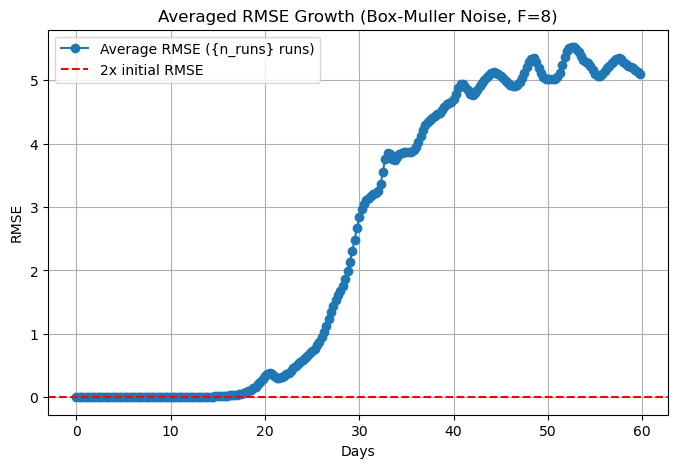

In [3]:
""" 
2. パラメータ値 F=8 とする。誤差の平均発達率について調べ、0.2 時間ステップを 1 日と定義することの妥当性を確認する。
"""

def box_muller(mu=0.0, sigma=1.0):
    """Generate a Gaussian random number using the Box-Muller transform."""
    u1 = random.random()
    u2 = random.random()
    r = math.sqrt(-2.0 * math.log(u1))
    theta = 2.0 * math.pi * u2
    return mu + sigma * r * math.cos(theta)

def rmse(a, b):
    """Calculate Root Mean Square Error between arrays a and b."""
    return np.sqrt(np.mean((a - b) ** 2))

# Set parameters
N = 40
F = 8
dt = 0.05           # 0.2 time units = 1 day
days = 60
steps = days * 4    # 1 step = 1 day in this setup
spinup_days = 365
spinup_steps = spinup_days * 4  # Spin-up time in steps

# Reference initial condition (noise-free)
x_ref = np.sin(np.arange(N) * 2 * np.pi / N) + F * np.ones(N)
# x_ref = F * np.ones(N)
# Spin up the reference trajectory
for t in range(spinup_steps):
    x_ref = rk4_step(x_ref, dt, F)
# Multi-run averaging
noise_scale = 0.00005
n_runs = 1000
avg_rmse_vals = np.zeros(steps)

for run in range(n_runs):
    # Create a new noisy initial condition for each run
    x_noisy_run = np.copy(x_ref)
    for i in range(N):
        x_noisy_run[i] += box_muller(0.0, noise_scale)
    
    # Allocate storage for single-run trajectories
    traj_ref_run = np.zeros((steps, N))
    traj_noisy_run = np.zeros((steps, N))
    rmse_vals_run = np.zeros(steps)

    # Initial states for this run
    traj_ref_run[0] = x_ref
    traj_noisy_run[0] = x_noisy_run
    rmse_vals_run[0] = rmse(x_ref, x_noisy_run)
    
    # Time integration for this run
    for t in range(1, steps):
        traj_ref_run[t] = rk4_step(traj_ref_run[t - 1], dt, F)
        traj_noisy_run[t] = rk4_step(traj_noisy_run[t - 1], dt, F)
        rmse_vals_run[t] = rmse(traj_ref_run[t], traj_noisy_run[t])
    
    # Accumulate for averaging
    avg_rmse_vals += rmse_vals_run

# Final average over all runs
avg_rmse_vals /= n_runs

# Determine when average RMSE doubles
initial_err = avg_rmse_vals[0]
threshold = 2.0 * initial_err
doubling_day = None
for step in range(1, steps):
    if avg_rmse_vals[step] >= threshold:
        doubling_day = step / 4.0  # 4 steps = 1 day
        break

print(f"Average initial RMSE = {initial_err:.6f}")
if doubling_day is not None:
    print(f"Average RMSE doubled on Day {doubling_day}.")
else:
    print("Average RMSE did not double within this period.")

# Plot averaged RMSE evolution
plt.figure(figsize=(8,5))
days_axis = np.arange(steps) / 4.0
plt.plot(days_axis, avg_rmse_vals, marker='o', label='Average RMSE ({n_runs} runs)')
plt.axhline(threshold, color='r', linestyle='--', label='2x initial RMSE')
plt.title("Averaged RMSE Growth (Box-Muller Noise, F=8)")
plt.xlabel("Days")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
"""
３．2 年分積分し、最初の 1 年分をスピンアップとして捨てる。後半 1 年分を 6 時間毎に保存しておく。
"""
N = 40
F = 8
spinup_days = 365
data_days = 365
total_days = spinup_days + data_days  # 2 years total
dt = 0.05  # 6 hours per step
steps_per_day = 4
spinup_steps = spinup_days * steps_per_day
total_steps = total_days * steps_per_day

# Initial condition
x0 = F * np.ones(N)
x0[N // 2 - 1] *= 1.001
trajectory = np.zeros((total_steps, N))
x = x0.copy()

# Integrate for 2 years
for t in range(total_steps):
    x = rk4_step(x, dt, F)
    trajectory[t] = x

# Discard first year (spin-up), keep second year data
stored_data = trajectory[spinup_steps:].copy()  # shape = (data_days*steps_per_day, N)


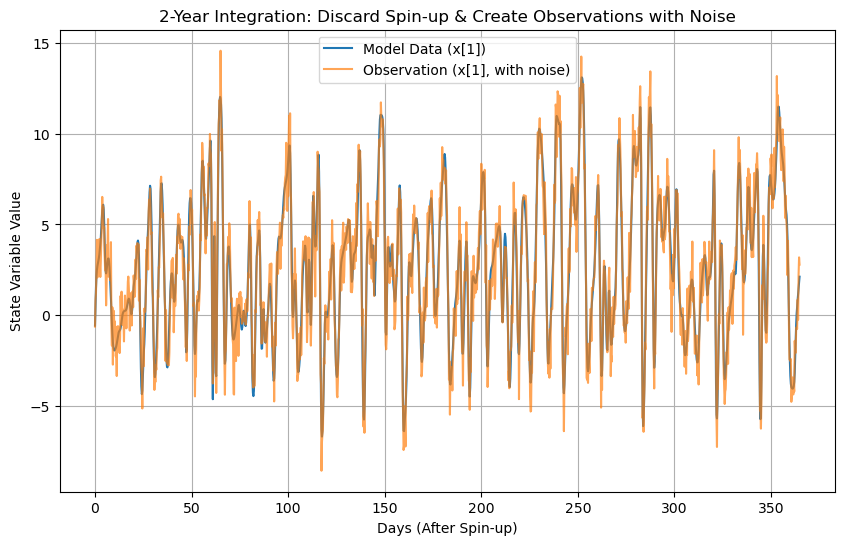

In [5]:
"""
４． Mersenne Twister 等の性質の良い乱数生成プログラムを用いて分散 1 の正規分布乱数を生成し、３で保存した 6 時間毎の場に足しこんで、別途保存する。これを観測データとする。
"""
obs_data = stored_data.copy()
for t in range(obs_data.shape[0]):
    for i in range(N):
        obs_data[t, i] += random.gauss(0.0, 1.0)

# Then you can save both stored_data and obs_data if desired:
# np.save("stored_data.npy", stored_data)
# np.save("obs_data.npy", obs_data)

plt.figure(figsize=(10, 6))
days_axis = np.arange(stored_data.shape[0]) / steps_per_day
plt.plot(days_axis, stored_data[:, 1], label="Model Data (x[1])")
plt.plot(days_axis, obs_data[:, 1], label="Observation (x[1], with noise)", alpha=0.7)
plt.xlabel("Days (After Spin-up)")
plt.ylabel("State Variable Value")
plt.title("2-Year Integration: Discard Spin-up & Create Observations with Noise")
plt.legend()
plt.grid(True)
plt.show()

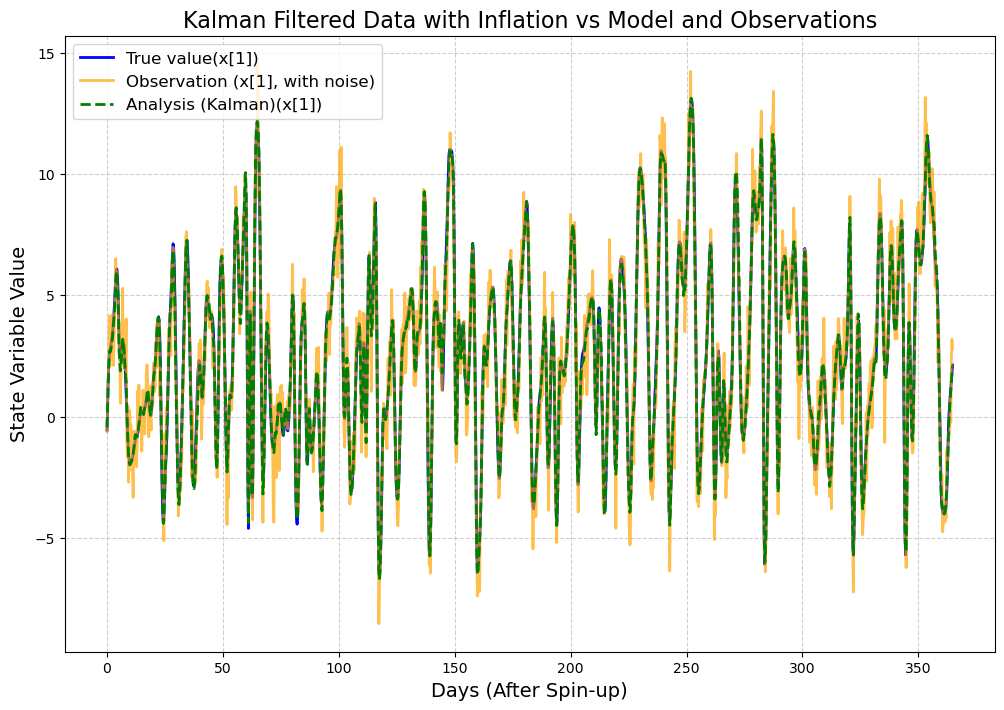

In [6]:
"""
５．6 時間サイクルのデータ同化システムを構築する。KF の式を直接解くものでよい。ただし、
KF の予報誤差共分散の部分に定数を入れられるように設計しておく。（定数を入れると、3 次元
変分法と同値である）
"""
def tangent_linear(model,x,delta=0.0, **kwargs):       
    """
    tangent linear model for Lorenz 96.
    
    Parameters:
    model : function
        Function to compute the state transition matrix.
    x : np.ndarray
        State vector.
    delta : float
        approximation parameter for the differentiation.

    Returns:
    M : np.ndarray
        Tangent Linear Mode(Jacobian of M).
    """ 
    N = len(x)
    M = np.zeros((N, N))
    
    # Fill the Jacobian matrix
    for i in range(N):
        M[:,i] = model(x + delta * np.eye(N)[:,i], dt=0.05/3, F=8) - model(x, dt=0.05/3, F=8)
    M /=  delta 
    return M
    

def kalman_filter(x, P, H, R, y, Q, model=rk4_step,alpha=0.0):
    """
    Kalman Filter update step with inflation factor.
    
    Parameters:
    x : np.ndarray
        State vector.
    P : np.ndarray
        State covariance matrix.
    H : np.ndarray
        Observation matrix.
    R : np.ndarray
        Observation noise covariance matrix.
    y : np.ndarray
        Observation vector.
    M : function
        
    Q : np.ndarray
        Process noise covariance matrix.
    model : 
        Function to update the state.
    alpha : float
        Inflation factor for the covariance matrix.
    
    Returns:
    x_new : np.ndarray
        Updated state vector.
    P_new : np.ndarray
        Updated state covariance matrix.
    """
    
    M_1 = tangent_linear(model=rk4_step, x=x, delta=0.00001)  
    x_1 = model(x, dt=0.05/3, F=8)
    M_2 = tangent_linear(model=rk4_step, x=x_1, delta=0.00001) 
    x_2 = model(x_1, dt=0.05/3, F=8)
    M_3 = tangent_linear(model=rk4_step, x=x_2, delta=0.00001)  
    x_pred = model(x_2, dt=0.05/3, F=8) # State prediction non linear 
    P_pred = M_3 @ M_2 @ M_1 @ P @ M_1.T @ M_2.T @ M_3.T+ Q  # Covariance prediction
    P_pred *= (1 + alpha)  # Apply inflation factor

    # Update step
    innovation = y - H @ x_pred  # Innovation (residual)
    S = H @ P_pred @ H.T + R  # Innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain

    x_new = x_pred + K @ innovation  # Updated state estimate
    P_new = (np.eye(len(P)) - K @ H) @ P_pred  # Updated covariance estimate

    return x_new, P_new

# Kalman Filter parameters
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance (identity for simplicity)
Q = np.eye(N) * 0  # Process noise covariance (small value)
P = np.eye(N) * 10  # Initial state covariance (uncertainty in initial state)
x = stored_data[0,:]  # Initial state estimate (zero for simplicity)
alpha = 0.05  # Inflation factor

# Storage for filtered data
filtered_data = np.zeros_like(obs_data)  # Shape: (data_days*steps_per_day, N)

# Kalman Filter loop
for t in range(obs_data.shape[0]):
    # Update the Kalman Filter with the observation
    x, P = kalman_filter(x, P, H, R, obs_data[t], Q,rk4_step,alpha=0.09)
    filtered_data[t] = x  # Store the filtered state

# Plotting the results with improved visibility
plt.figure(figsize=(12, 8))
days_axis = np.arange(obs_data.shape[0]) / steps_per_day
plt.plot(days_axis, stored_data[:, 1], label="True value(x[1])", linewidth=2, color='blue')
plt.plot(days_axis, obs_data[:, 1], label="Observation (x[1], with noise)", linewidth=2, color='orange', alpha=0.7)
plt.plot(days_axis, filtered_data[:, 1], label="Analysis (Kalman)(x[1])", linestyle='--', linewidth=2, color='green')
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("State Variable Value", fontsize=14)
plt.title("Kalman Filtered Data with Inflation vs Model and Observations", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



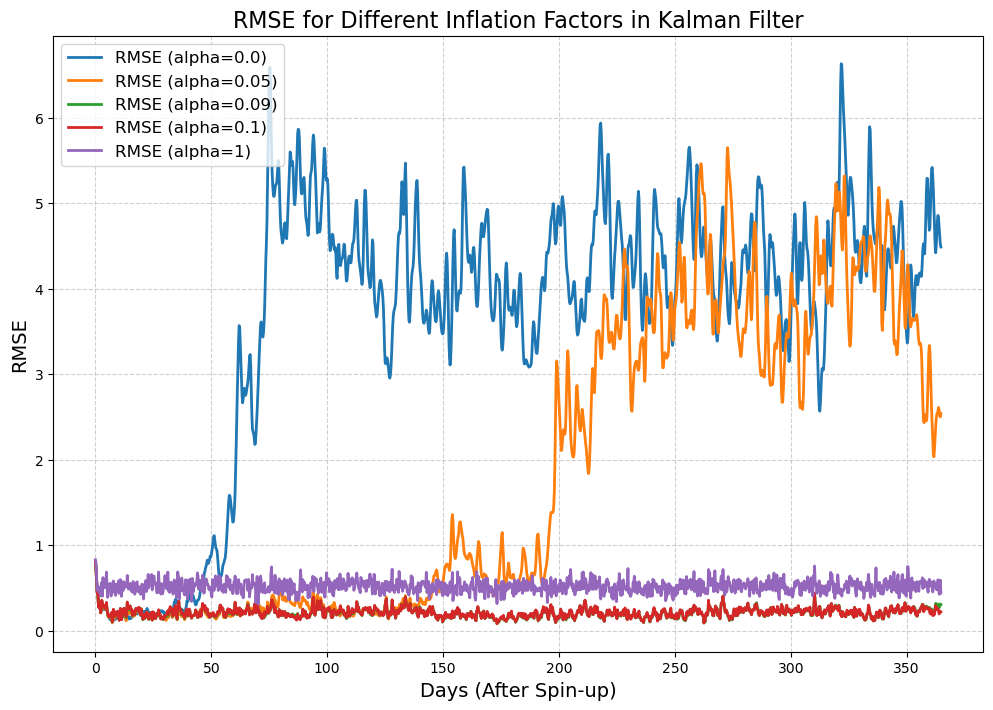

In [9]:
#Evaluate KF performance for different inflation factors
alphas = [0.0, 0.05,0.09 , 0.1,1]  # List of inflation factors to test
rmse_results = []

for alpha in alphas:
    x = stored_data[0, :]  # Reset initial state estimate
    P = np.eye(N) * 10  # Reset initial covariance matrix
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])  # Store RMSE values for this alpha

    # Kalman Filter loop
    for t in range(obs_data.shape[0]):
        x, P = kalman_filter(x, P, H, R, obs_data[t], Q, rk4_step, alpha)
        filtered_data[t] = x
        rmse_value = rmse(stored_data[t], filtered_data[t])
        rmse_values[t] = rmse_value  # Store RMSE for this time step)

    # Compute RMSE for this alpha
    rmse_results.append(rmse_values)

# Plot RMSE vs alpha
plt.figure(figsize=(12, 8))
for i, alpha in enumerate(alphas):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results[i], label=f"RMSE (alpha={alpha})", linewidth=2)
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE for Different Inflation Factors in Kalman Filter", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [10]:
print(np.mean(rmse_results[2][500:]))
print(np.mean(rmse_results[3][500:]))

0.2080689154170855
0.2101326735408337


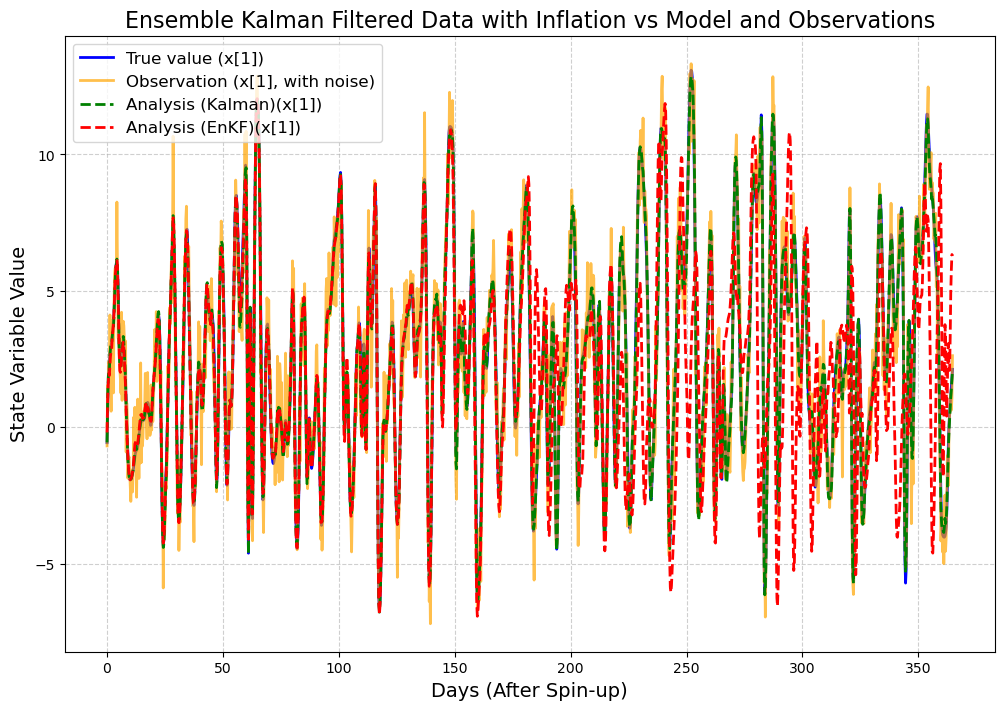

In [9]:
"""
７． EnKF を実装し、 KF との比較実験を行う。 Whitaker and Hamill (2002, MWR)による EnSRF
や、Bishop et al. (2001, MWR)による ETKF、Hunt et al. (Physica D, 2007)による LETKF 等。
"""
def ensemble_kalman_filter(ensemble, H, R, y, Q, model=rk4_step, alpha=0.0):
    """
    A simple stochastic EnKF updating each ensemble member (with perturbed obs).
    
    Parameters:
    -----------
    ensemble : np.ndarray
        Shape (Nx, m). Nx = state dimension, m = ensemble size.
    H : np.ndarray
        Observation operator of shape (Ny, Nx).
    R : np.ndarray
        Observation error covariance of shape (Ny, Ny).
    y : np.ndarray
        Observed vector of shape (Ny,).
    Q : np.ndarray
        Process noise covariance of shape (Nx, Nx).
    model : function
        Model propagation function that takes a state vector and returns the next state.
    alpha : float
        Inflation factor for the forecast covariance.

    Returns:
    --------
    updated_ensemble : np.ndarray
        The updated ensemble with shape (Nx,m).
    """
    Nx, m = ensemble.shape  # m ensemble members, Nx state dimension

    # 1) Forecast each member forward
    ens_forecast = np.zeros_like(ensemble)
    for i in range(m):
        ens_forecast[:, i] = model(ensemble[:, i], dt=0.05, F=8)

    # 2) Compute forecast mean and anomalies
    x_bar = np.mean(ens_forecast, axis=1)  # shape (Nx,)
    X_f = ens_forecast - x_bar[:, None]     # shape (Nx, m)

    # 3) Forecast covariance and inflation
    X_f *= np.sqrt(1 + alpha)                        # Inflate the anomalies
    Pf = (X_f @ X_f.T) / (m - 1) + Q                  # background covariance
    
    # 4) Perturb observations for each ensemble member (PO)
    Ny = H.shape[0]
    # np.random.multivariate_normal gives shape (m, Ny), so transpose to (Ny, m)
    obs_perturb = np.random.multivariate_normal(mean=np.zeros(Ny), cov=R, size=m).T  
    # H @ ens_forecast is Ny×m, so we can add the perturbations directly
    Y_ens = (H @ ens_forecast) + obs_perturb  # shape (Ny, m)

    # 5) Compute Kalman gain
    S = H @ Pf @ H.T + R                              # innovation covariance
    K = Pf @ H.T @ np.linalg.inv(S)                   # Kalman gain

    # 6) Update each ensemble member
    updated_ensemble = np.zeros_like(ens_forecast)
    for i in range(m):
        innovation_i = y - Y_ens[:, i]               # shape (Ny,)
        updated_ensemble[:, i] = ens_forecast[:, i] + K @ innovation_i

    return updated_ensemble

# Ensemble Kalman Filter parameters
ensemble_size = 100  

P = np.eye(N) * 1   # Initial state covariance 
x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T # Initial ensemble members 　
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance 
Q = np.eye(N) * 0  # Process noise covariance 
alpha = 0.5  # Inflation factor
# Storage for filtered data     
filtered_data_enkf = np.zeros_like(obs_data)  # Shape: (data_days*steps_per_day, N)

# Kalman Filter loop
for t in range(obs_data.shape[0]):
    x = ensemble_kalman_filter(x, H, R, obs_data[t], Q, rk4_step, alpha)
    filtered_data_enkf[t] = np.mean(x, axis=1)
# Plotting the results with improved visibility
plt.figure(figsize=(12, 8))
days_axis = np.arange(obs_data.shape[0]) / steps_per_day    
plt.plot(days_axis, stored_data[:, 1], label="True value (x[1])", linewidth=2, color='blue')
plt.plot(days_axis, obs_data[:, 1], label="Observation (x[1], with noise)", linewidth=2, color='orange', alpha=0.7)
plt.plot(days_axis, filtered_data[:, 1], label="Analysis (Kalman)(x[1])", linestyle='--', linewidth=2, color='green')
plt.plot(days_axis, filtered_data_enkf[:, 1], label="Analysis (EnKF)(x[1])", linestyle='--', linewidth=2, color='red')
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("State Variable Value", fontsize=14)
plt.title("Ensemble Kalman Filtered Data with Inflation vs Model and Observations", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Running EnKF with ensemble size 20
Running EnKF with ensemble size 50
Running EnKF with ensemble size 100
Running EnKF with ensemble size 200
Running EnKF with ensemble size 500


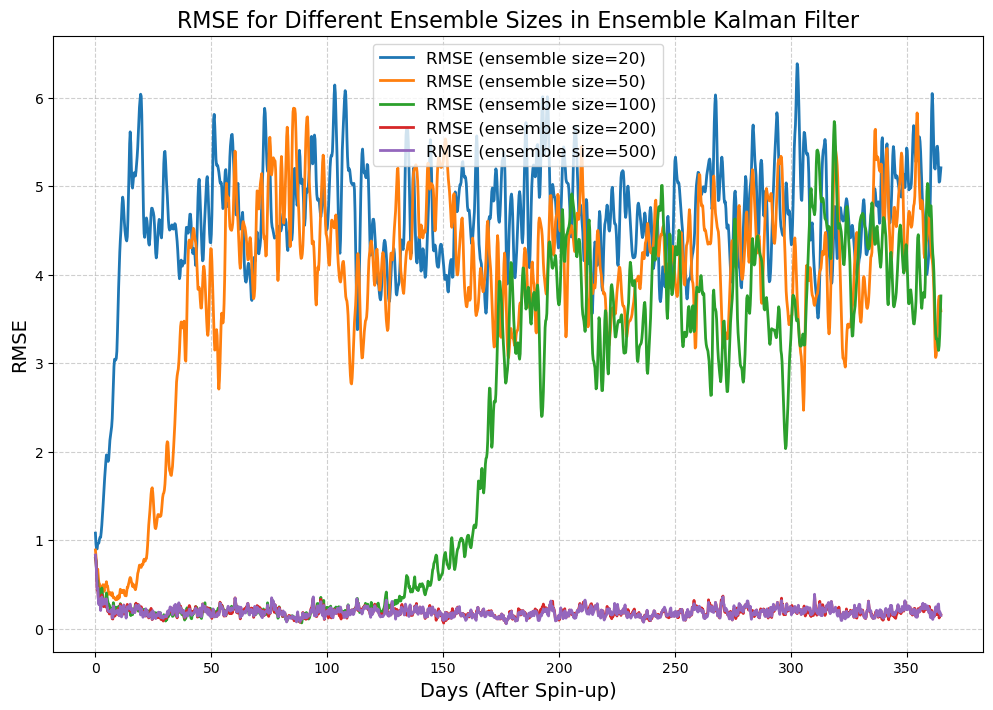

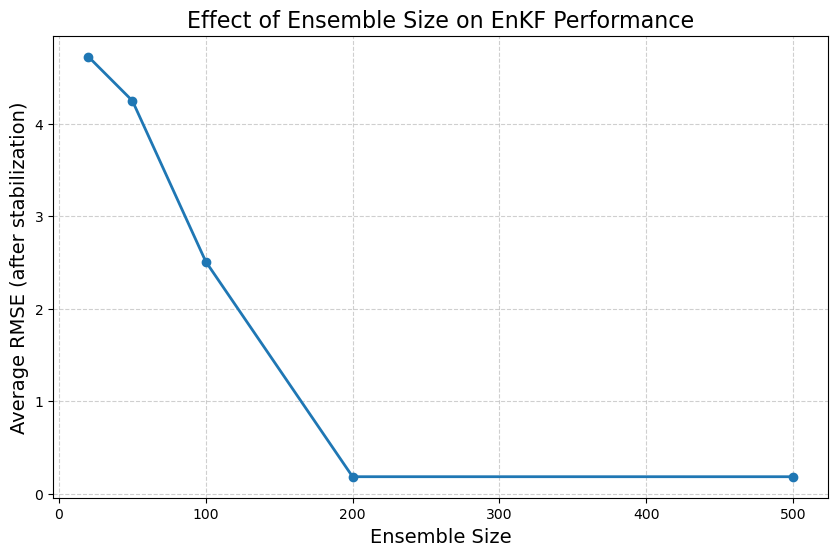

In [12]:
# Compare EnKF performance for different ensemble sizes
ensemble_sizes = [20, 50, 100, 200, 500]  # List of ensemble sizes to test
# ensemble_sizes = [20, 50]  # List of ensemble sizes to test
rmse_results_enkf = []

for ens_size in ensemble_sizes:
    print(f"Running EnKF with ensemble size {ens_size}")
    
    # Reset initial ensemble
    P = np.eye(N) * 10  # Initial state covariance
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T  # Initial ensemble members
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])  # Store RMSE values for this ensemble size
    
    # EnKF loop
    for t in range(obs_data.shape[0]):
        x = ensemble_kalman_filter(x, H, R, obs_data[t], Q, rk4_step, alpha)
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = rmse(stored_data[t], filtered_data[t])
    
    # Compute RMSE for this ensemble size
    rmse_results_enkf.append(rmse_values)

# Plot RMSE vs ensemble size
plt.figure(figsize=(12, 8))
for i, ens_size in enumerate(ensemble_sizes):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_enkf[i], label=f"RMSE (ensemble size={ens_size})", linewidth=2)

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE for Different Ensemble Sizes in Ensemble Kalman Filter", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization (e.g., after day 50)
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_enkf]

plt.figure(figsize=(10, 6))
plt.plot(ensemble_sizes, avg_rmse_by_size, 'o-', linewidth=2)
plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title("Effect of Ensemble Size on EnKF Performance", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [13]:
print(avg_rmse_by_size)

[4.724590033279853, 4.248061933785758, 2.5092649012269357, 0.18421804584589904, 0.18402603217800506]


In [10]:
def ensemble_transform_kalman_filter(ensemble, H, R, y, Q, model=rk4_step, alpha=0.0):
    """ 
    Ensemble Transform Kalman Filter (ETKF) update step with inflation factor.

    Parameters:     
    -----------
    ensemble : np.ndarray
        Shape (Nx, m). Nx = state dimension, m = ensemble size.
    H : np.ndarray
        Observation operator of shape (Ny, Nx).
    R : np.ndarray
        Observation error covariance of shape (Ny, Ny).
    y : np.ndarray
        Observed vector of shape (Ny,).
    Q : np.ndarray
        Process noise covariance of shape (Nx, Nx).
    model : function
        Model propagation function that takes a state vector and returns the next state.
    alpha : float
        Inflation factor for the forecast covariance.
    Returns:
    --------
    updated_ensemble : np.ndarray
        The updated ensemble with shape (Nx, m).            
    """
    Nx, m = ensemble.shape
    Ny = H.shape[0]

    # 1) Forecast step
    ens_forecast = np.zeros_like(ensemble)
    for i in range(m):
        ens_forecast[:, i] = model(ensemble[:, i], dt=0.05, F=8)

    # 2) Mean, anomalies, inflation
    x_bar = np.mean(ens_forecast, axis=1)  # shape (Nx,)
    delta_Xb = ens_forecast - x_bar[:, None]  # (Nx, m)
    
    # 3) Project to observation space
    y_bar = H @ x_bar                      # shape (Ny,)
    delta_Yb = H @ delta_Xb                          # shape (Ny, m)
    d = y - y_bar                          # innovation, shape (Ny,)

    # 4) ETKF update
    Yb_rinv = delta_Yb.T @ np.linalg.inv(R)             # shape (m, Ny)
    P_tilde_inv = np.eye(m) * (m-1)/(1 + alpha) + (Yb_rinv @ delta_Yb)   # shape (m, m)

    U, s, Vt = np.linalg.svd(P_tilde_inv)
    # Weights for mean
    w = (U @ np.diag(1.0 / s) @ U.T @ Yb_rinv @ d)   # shape (m,)

    x_a = x_bar + delta_Xb @ w  # Updated mean, shape (Nx,)

    # Compute transform for perturbations
    T = U @ np.diag(1.0 / np.sqrt(s)) @ U.T * np.sqrt(m - 1)  # shape (m, m)
    delta_Xa = delta_Xb @ T  # (Nx, m)

    # 5) Form updated ensemble
    updated_ensemble = x_a[:, None] + delta_Xa  # shape (Nx, m)

    return updated_ensemble

Testing EnKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200
Testing ETKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200


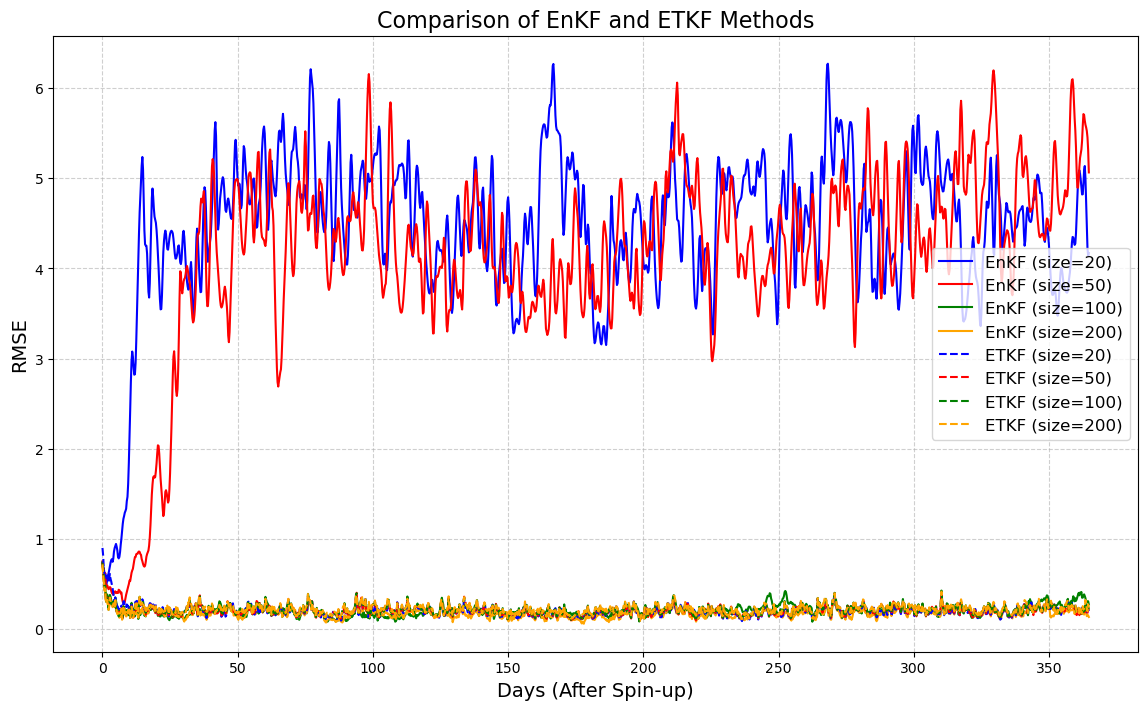

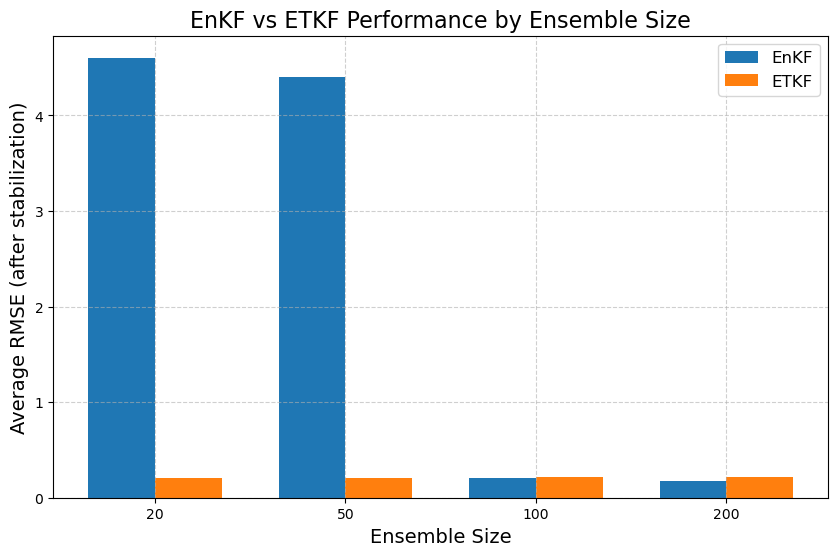

In [15]:
# Compare EnKF and ETKF performance
ensemble_sizes = [20, 50, 100,200]  # List of ensemble sizes to test
methods = ["EnKF", "ETKF"]
rmse_results_all = []


H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance 
Q = np.eye(N) * 0  # Process noise covariance 

for method in methods:
    print(f"Testing {method} method...")
    rmse_results_method = []
    
    for ens_size in ensemble_sizes:
        print(f"Running with ensemble size {ens_size}")
        
        # Reset initial ensemble
        P = np.eye(N) * 1
        x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T
        
        filtered_data = np.zeros_like(obs_data)
        rmse_values = np.zeros(obs_data.shape[0])
        
        # Filter loop
        for t in range(obs_data.shape[0]):
            if method == "EnKF":
                x = ensemble_kalman_filter(x, H, R, obs_data[t], Q, rk4_step, alpha=0.09)
            else:  # ETKF
                x = ensemble_transform_kalman_filter(x, H, R, obs_data[t], Q, rk4_step, alpha=0.09)
            
            filtered_data[t] = np.mean(x, axis=1)
            rmse_values[t] = rmse(stored_data[t], filtered_data[t])
        
        rmse_results_method.append(rmse_values)
    
    rmse_results_all.append(rmse_results_method)

# Plot comparison of methods
plt.figure(figsize=(14, 8))
linestyles = ['-', '--']
colors = ['blue', 'red', 'green', 'orange']

for i, method in enumerate(methods):
    for j, ens_size in enumerate(ensemble_sizes):
        days_axis = np.arange(obs_data.shape[0]) / steps_per_day
        plt.plot(days_axis, rmse_results_all[i][j], 
                 label=f"{method} (size={ens_size})", 
                 linestyle=linestyles[i], 
                 color=colors[j])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Comparison of EnKF and ETKF Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_method = []

for i, method in enumerate(methods):
    avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_all[i]]
    avg_rmse_by_method.append(avg_rmse_by_size)

# Bar plot for average RMSE comparison
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(ensemble_sizes))

for i, method in enumerate(methods):
    plt.bar(x + i*width, avg_rmse_by_method[i], width, label=method)

plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title("EnKF vs ETKF Performance by Ensemble Size", fontsize=16)
plt.xticks(x + width/2, ensemble_sizes)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [11]:
def local_ensemble_transform_kalman_filter(ensemble, H, R, y, Q, loc_radius=5, model=rk4_step, alpha=0.0):
    """
    Local Ensemble Transform Kalman Filter (LETKF) with R-localization.
    
    Parameters:
    -----------
    ensemble : np.ndarray
        Shape (Nx, m). Nx = state dimension, m = ensemble size.
    H : np.ndarray
        Observation operator of shape (Ny, Nx).
    R : np.ndarray
        Observation error covariance of shape (Ny, Ny) (assume diagonal).
    y : np.ndarray
        Observed vector of shape (Ny,).
    Q : np.ndarray
        Process noise covariance of shape (Nx, Nx).
    loc_radius : float
        Localization radius (sigma in the Gaussian localization function).
    model : function
        Model propagation function that takes a state vector and returns the next state.
    alpha : float
        Inflation factor for the forecast covariance.
        
    Returns:
    --------
    updated_ensemble : np.ndarray
        The updated ensemble with shape (Nx, m).
    """
    Nx, m = ensemble.shape
    Ny = H.shape[0]
    
    # 1) Forecast step
    ens_forecast = np.zeros_like(ensemble)
    for i in range(m):
        ens_forecast[:, i] = model(ensemble[:, i], dt=0.05, F=8)
    
    # 2) Mean, anomalies
    x_bar = np.mean(ens_forecast, axis=1)           # shape (Nx,)
    delta_Xb = ens_forecast - x_bar[:, None]        # shape (Nx, m)
      
    # 3) Project to observation space
    y_bar = H @ x_bar                      # shape (Ny,)
    delta_Yb = H @ delta_Xb                     # shape (Ny, m)
    d = y - y_bar                          # innovation, shape (Ny,)
    
    # 4) Define localization function (Gaussian with cutoff)
    def localization_function(distance, sigma=loc_radius):
        """Gaussian localization function with cutoff"""
        cutoff = 2 * np.sqrt(10.0/3.0) * sigma
        if distance < cutoff:
            return np.exp(-0.5 * (distance**2) / (sigma**2))
        else:
            return 0.0
    
     # 5) Local analysis
    analysis_ensemble = np.zeros_like(ens_forecast)
    for i in range(Nx):
        # Build localized R
        R_loc = np.diag(np.diag(R).copy())
        for j in range(Ny):
            dist = min(abs(i - j), Nx - abs(i - j))
            loc_factor = localization_function(dist)
            R_loc[j, j] = (R_loc[j, j] / loc_factor) if loc_factor > 0 else 1.0e10

        R_loc_inv = np.diag(1.0 / np.diag(R_loc))

        # ETKF style update
        Yb_rinv = delta_Yb.T @ R_loc_inv
        P_tilde_inv = np.eye(m) * (m - 1) / (1 + alpha) + Yb_rinv @ delta_Yb

        U, s, Vt = np.linalg.svd(P_tilde_inv)
        w = (U @ np.diag(1.0 / s) @ U.T) @ (Yb_rinv @ d)
        T = U @ np.diag(1.0 / np.sqrt(s)) @ U.T * np.sqrt(m - 1)

        # Local update
        x_a_i = x_bar[i] + delta_Xb[i, :] @ w
        delta_Xa_i = delta_Xb[i, :] @ T
        analysis_ensemble[i, :] = x_a_i + delta_Xa_i

    return analysis_ensemble


Testing ENKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200
Testing LETKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200


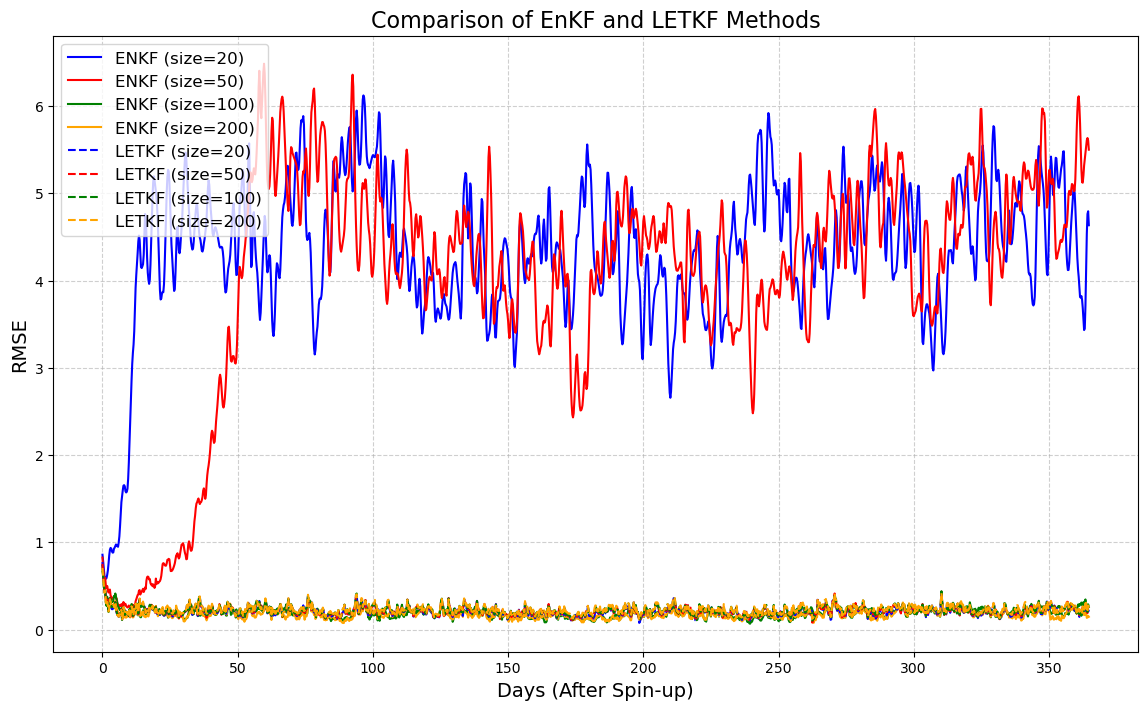

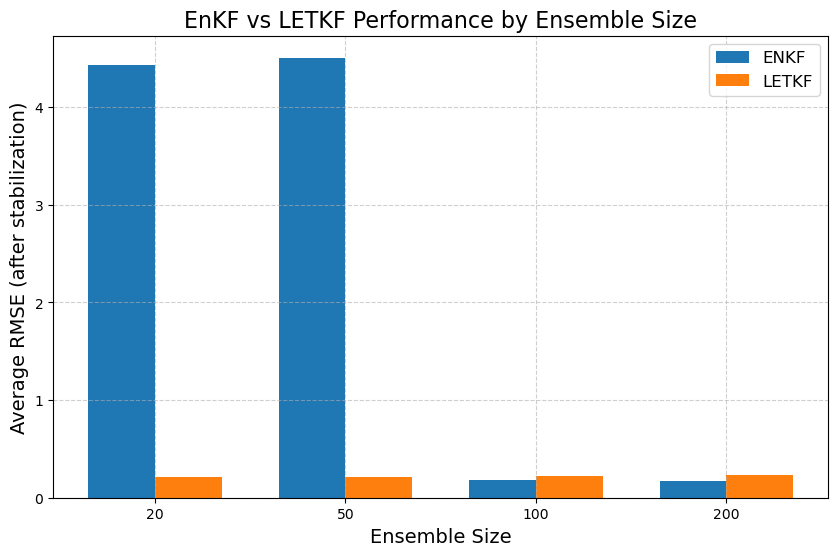

In [17]:
# Compare LETKF performance
ensemble_sizes = [20, 50, 100, 200]  # List of ensemble sizes to test
methods = ["ENKF","LETKF"]
rmse_results_all = []
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance           

for method in methods:      
    print(f"Testing {method} method...")
    rmse_results_method = []
    
    for ens_size in ensemble_sizes:
        print(f"Running with ensemble size {ens_size}")
        
        # Reset initial ensemble
        P = np.eye(N) * 1
        x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T
        
        filtered_data = np.zeros_like(obs_data)
        rmse_values = np.zeros(obs_data.shape[0])
        
        # Filter loop
        for t in range(obs_data.shape[0]):
            if method == "ENKF":
                x = ensemble_kalman_filter(x, H, R, obs_data[t], Q, rk4_step, alpha=0.09)
            else:  # LETKF
                x = local_ensemble_transform_kalman_filter(x, H, R, obs_data[t], Q, loc_radius=5, model=rk4_step, alpha=0.09)
            
            filtered_data[t] = np.mean(x, axis=1)
            rmse_values[t] = rmse(stored_data[t], filtered_data[t])
        
        rmse_results_method.append(rmse_values)
    
    rmse_results_all.append(rmse_results_method)

    
# Plot comparison of methods
plt.figure(figsize=(14, 8))
linestyles = ['-', '--']
colors = ['blue', 'red', 'green', 'orange'] 
for i, method in enumerate(methods):
    for j, ens_size in enumerate(ensemble_sizes):
        days_axis = np.arange(obs_data.shape[0]) / steps_per_day
        plt.plot(days_axis, rmse_results_all[i][j], 
                 label=f"{method} (size={ens_size})", 
                 linestyle=linestyles[i], 
                 color=colors[j])
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Comparison of EnKF and LETKF Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_method = []
for i, method in enumerate(methods):
    avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_all[i]]
    avg_rmse_by_method.append(avg_rmse_by_size)


# Bar plot for average RMSE comparison
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(ensemble_sizes))
for i, method in enumerate(methods):
    plt.bar(x + i*width, avg_rmse_by_method[i], width, label=method)
plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title("EnKF vs LETKF Performance by Ensemble Size", fontsize=16)
plt.xticks(x + width/2, ensemble_sizes)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
print(avg_rmse_by_method)

[[4.431299736574373, 4.507150483922997, 0.18568715760662963, 0.17295490014426101], [0.21081446174441634, 0.2158254317445508, 0.22110737125295024, 0.22827574228712733]]


In [7]:

def mc_resampling_matrix(weights, m, n_samples=30):
    """
    Generate an ensemble transform (resampling) matrix T for LPF via Monte-Carlo sampling.
    weights: array of shape (m,) with sum(weights)=1
    m: ensemble size
    n_samples: number of random samplings to average
    """
    T_avg = np.zeros((m, m))
    # Precompute cumulative weights
    cumulative_w = np.zeros(m+1)
    for i in range(m):
        cumulative_w[i+1] = cumulative_w[i] + weights[i]
    # Monte-Carlo averaging
    for _ in range(n_samples):
        # Draw m random numbers in [0,1] and sort
        r = np.sort(np.random.rand(m))
        idx = 0
        for j in range(m):
            while r[j] > cumulative_w[idx+1]:
                idx += 1
            T_avg[idx, j] += 1
    T_avg /= n_samples
    return T_avg

def local_particle_filter(ensemble, H, R, y, Q, weights=None, loc_radius=5, model=rk4_step, 
                          inflation_type="rtps", alpha=0.0, beta=0.0, 
                          n_samples=100, Neff_threshold=None, tau=0.1):
    """
    Local Particle Filter with Monte-Carlo-based resampling matrix and weight succession.
    
    Parameters:
    -----------
    ensemble : np.ndarray
        Shape (Nx, m). Nx = state dimension, m = ensemble size.
    H : np.ndarray
        Observation operator of shape (Ny, Nx).
    R : np.ndarray
        Observation error covariance of shape (Ny, Ny).
    y : np.ndarray
        Observed vector of shape (Ny,).
    Q : np.ndarray
        Process noise covariance of shape (Nx, Nx).
    weights : np.ndarray or None
        Previous weights from last analysis, shape (Nx, m).
        If None, initialize with uniform weights.
    loc_radius : float
        Localization radius (sigma in the Gaussian localization function).
    model : function
        Model propagation function that takes a state vector and returns the next state.
    inflation_type : str
        Type of inflation to apply: "rtps" (Relaxation to Prior Spread) or 
        "additive" (Additive Inflation) or "none".
    alpha : float
        RTPS inflation parameter for posterior ensemble spread (0 to 1).
    beta : float
        Additive inflation magnitude parameter.
    n_samples : int
        Number of Monte-Carlo samples to generate the transform matrix.
    Neff_threshold : float or None
        Effective ensemble size threshold for resampling.
    tau : float
        Forgetting factor for weight succession (0 ≤ τ ≤ 1).
        τ = 0: Full succession of posterior weights.
        τ = 1: Reset to uniform weights.
        
    Returns:
    --------
    updated_ensemble : np.ndarray
        The updated ensemble with shape (Nx, m).
    updated_weights : np.ndarray
        Updated weights with shape (Nx, m).
    """
    Nx, m = ensemble.shape
    Ny = H.shape[0]
    
    # Initialize weights if not provided
    if weights is None:
        weights = np.ones((Nx, m)) / m
    
    # 1) Forecast step
    ens_forecast = np.zeros_like(ensemble)
    for i in range(m):
        ens_forecast[:, i] = model(ensemble[:, i], dt=0.05, F=8)
    
    # 2) Compute weighted forecast mean and spread
    x_bar_f = np.mean(ens_forecast, axis=1)  # shape (Nx,)
    spread_f = np.std(ens_forecast, axis=1)  # shape (Nx,)

    y_ens = H @ ens_forecast  # shape (Ny, m)
    obs_diff = y.reshape(-1, 1) - y_ens  # shape (Ny, m)
    
    # 3) Define localization function (Gaussian with cutoff)
    def localization_function(distance, sigma=loc_radius):
        """Gaussian localization function with cutoff"""
        cutoff = 2 * np.sqrt(10.0/3.0) * sigma
        if distance < cutoff:
            return np.exp(-0.5 * (distance**2) / (sigma**2))
        else:
            return 0.0
    
    # 4) Local analysis for each grid point
    updated_ensemble = np.zeros((Nx, m)) 
    updated_weights = np.zeros((Nx, m))
    
    for i in range(Nx):
        # Build localized R for this grid point
        R_loc = np.diag(np.diag(R).copy())
        for j in range(Ny):
            # Calculate distance with periodic boundary conditions
            dist = min(abs(i - j), Nx - abs(i - j))
            loc_factor = localization_function(dist)
            R_loc[j, j] = (R_loc[j, j] / loc_factor) if loc_factor > 0 else 1.0e10
        
        # Compute observation likelihood with localized R
        invR_loc = np.diag(1.0 / np.diag(R_loc))  # Inverse of diagonal R_loc
        
        # Calculate likelihood weights
        quad_form = np.sum((obs_diff**2) * np.diag(invR_loc)[:,None], axis=0)  # shape (m,)
        likelihood_values = np.exp(-0.5 * quad_form)  # shape (m,)
        # Proper Bayesian update: posterior ∝ likelihood × prior
        posterior_weights = weights[i, :] * likelihood_values  # shape (m,)
        posterior_weights /= np.sum(posterior_weights)  # normalize

        # Check effective ensemble size with proper posterior weights
        Neff = 1.0 / np.sum(posterior_weights**2)        
                
        if Neff_threshold is not None and Neff >= Neff_threshold:
            # Skip resampling for this grid point
            updated_ensemble[i, :] = ens_forecast[i, :]
            
            # Apply weight succession formula: w_t+1 = (1-τ)·w_t + τ/m
            updated_weights[i, :] = (1 - tau) * posterior_weights + tau/m
        else:
            # Generate transform matrix via Monte-Carlo resampling
            T = mc_resampling_matrix(posterior_weights, m, n_samples=n_samples)
            
            # Apply transform to this grid point
            updated_ensemble[i, :] = ens_forecast[i, :] @ T
            
            # Reset weights to uniform after resampling
            updated_weights[i, :] = np.ones(m) / m
    
    # 5) Apply inflation according to selected method
    if inflation_type.lower() == "rtps" and alpha > 0.0:
        # RTPS inflation (Relaxation to Prior Spread)
        x_bar_a = np.mean(updated_ensemble, axis=1)  # shape (Nx,)
        perturbations_a = updated_ensemble - x_bar_a[:, None]  # shape (Nx, m)
        
        # Compute analysis spread
        spread_a = np.std(updated_ensemble, axis=1)  # shape (Nx,)
        
        # Apply RTPS formula for each state variable
        for k in range(Nx):
            # Avoid division by zero
            if spread_a[k] > 1e-10:
                rtps_factor = (1.0 - alpha) + alpha * (spread_f[k] / spread_a[k])
                perturbations_a[k, :] *= rtps_factor
        
        # Reconstruct ensemble
        updated_ensemble = x_bar_a[:, None] + perturbations_a
        
    elif inflation_type.lower() == "additive" and beta > 0.0:
        # Additive inflation: P_inf = P_orig + β*I
        x_bar_a = np.mean(updated_ensemble, axis=1)  # shape (Nx,)
        
        # Generate random perturbations with constant standard deviation sqrt(β)
        # This represents adding β to the diagonal of the covariance matrix
        for k in range(Nx):
            # Generate perturbations from N(0,β)
            rand_perturbations = np.random.normal(0, np.sqrt(beta), m)
            
            # Make sure perturbations have zero mean (preserve ensemble mean)
            rand_perturbations -= np.mean(rand_perturbations)
            
            # Add perturbations to ensemble members
            updated_ensemble[k, :] += rand_perturbations
    
    return updated_ensemble, updated_weights

Testing LPF with different localization radii (ensemble size=100)...
Running LPF with radius=0.5
Running LPF with radius=1


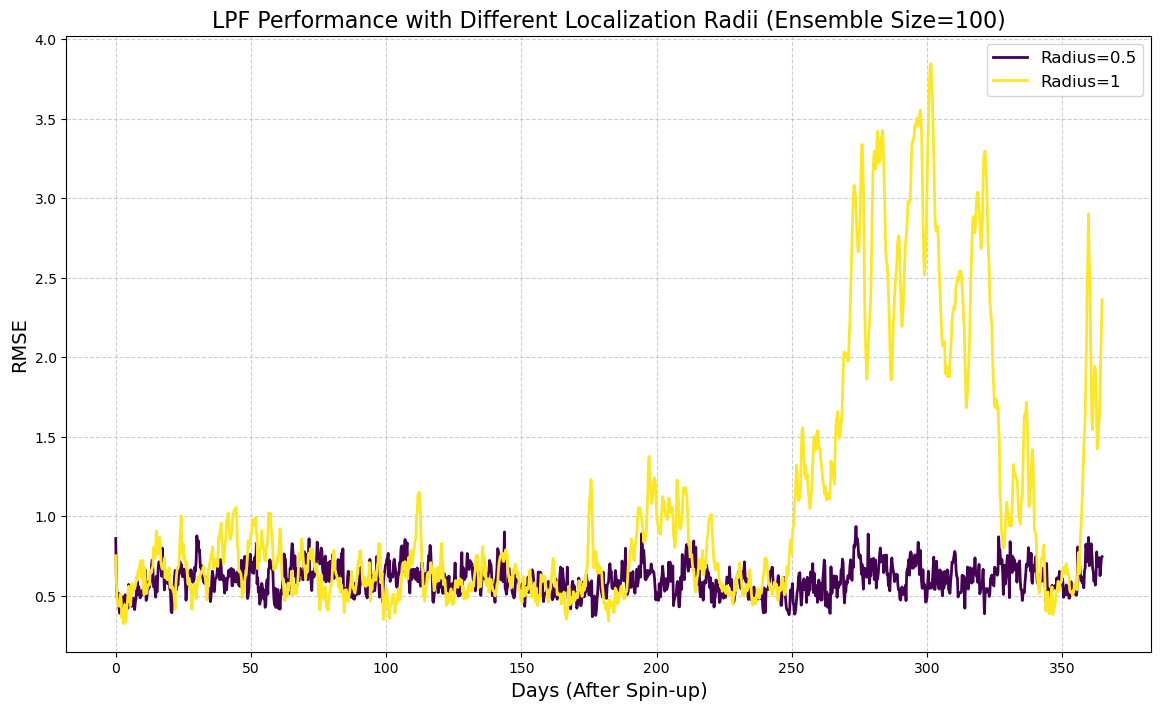

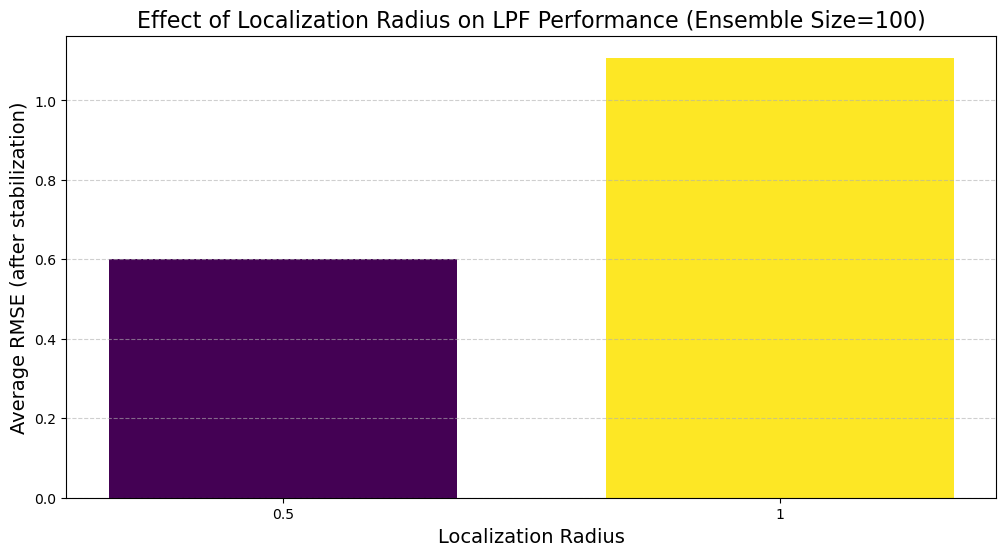

Best localization radius: 0.5 with average RMSE: 0.601837

Detailed results:
Radius 0.5: Average RMSE = 0.601837
Radius 1: Average RMSE = 1.107521


In [20]:
# Compare LPF performance with different localization radii
ensemble_size = 100  # Fixed ensemble size
radius_list = [0.5,1]  # Different radii to test
rmse_results_radius = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPF with different localization radii (ensemble size={ensemble_size})...")

for radius in radius_list:
    print(f"Running LPF with radius={radius}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this radius
    for t in range(obs_data.shape[0]):
        x, weights = local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=radius,
            model=rk4_step, 
            alpha=0.7,
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this radius
    rmse_results_radius.append(rmse_values)

# Plot RMSE vs time for different radii
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(radius_list)))

for i, radius in enumerate(radius_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_radius[i], 
             label=f"Radius={radius}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Localization Radii (Ensemble Size={ensemble_size})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_radius = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_radius]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(radius_list)), avg_rmse_by_radius, color=colors, width=0.7)
plt.xticks(range(len(radius_list)), [str(r) for r in radius_list])
plt.xlabel("Localization Radius", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Localization Radius on LPF Performance (Ensemble Size={ensemble_size})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best radius
best_idx = np.argmin(avg_rmse_by_radius)
print(f"Best localization radius: {radius_list[best_idx]} with average RMSE: {avg_rmse_by_radius[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, radius in enumerate(radius_list):
    print(f"Radius {radius}: Average RMSE = {avg_rmse_by_radius[i]:.6f}")

Testing LPF with different inflation parameters (fixed radius=0.1, ensemble size=100)...
Running LPF with alpha=0.0
Running LPF with alpha=0.1
Running LPF with alpha=0.3
Running LPF with alpha=0.5
Running LPF with alpha=0.7
Running LPF with alpha=0.9


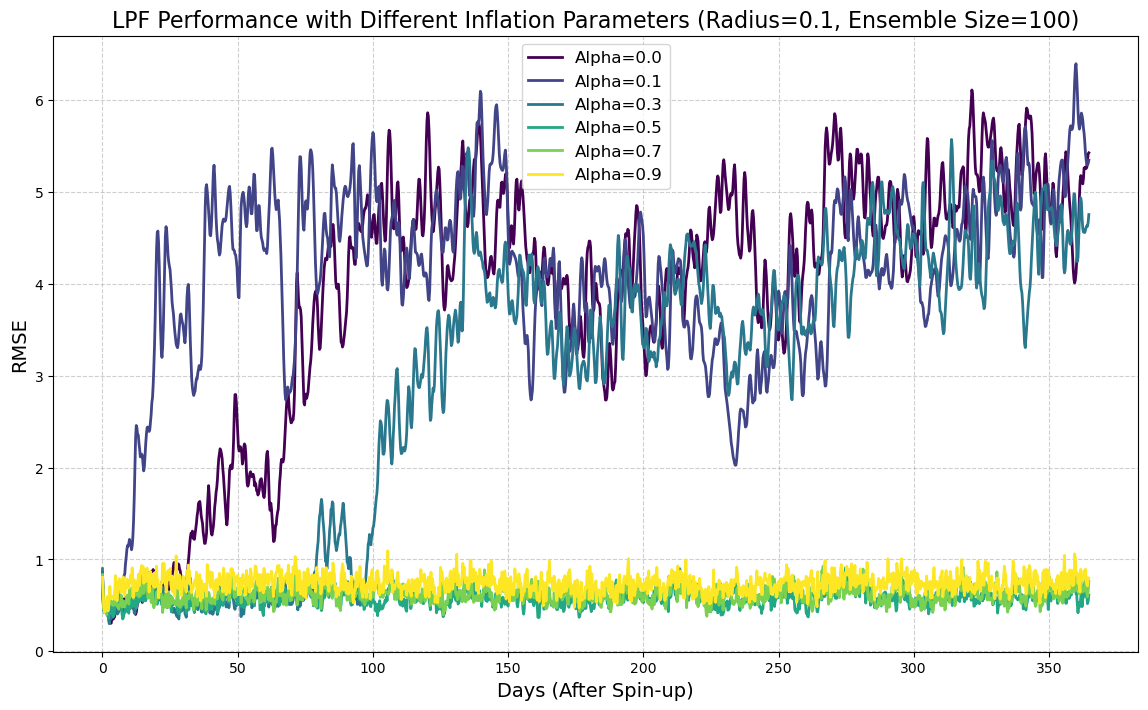

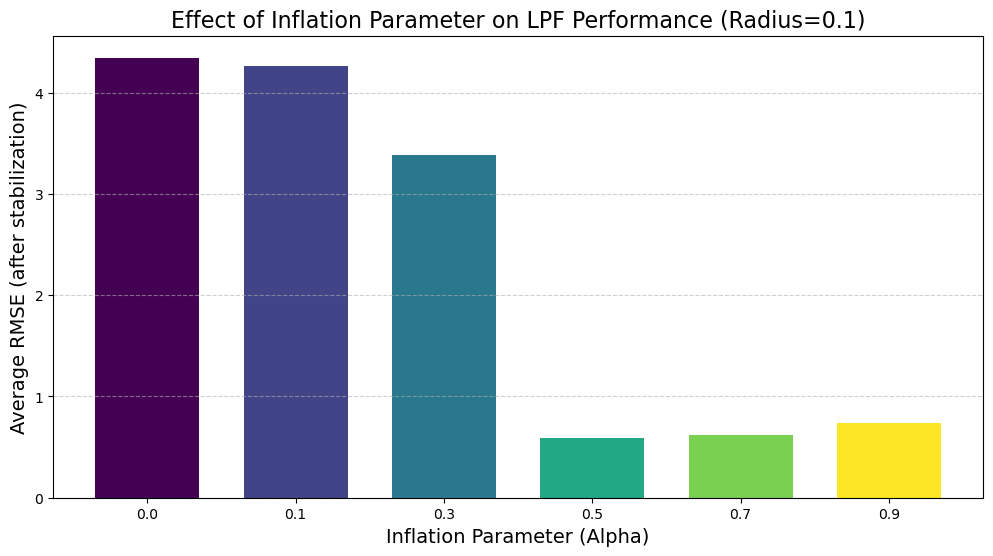

Best inflation parameter: 0.5 with average RMSE: 0.589121

Detailed results:
Alpha 0.0: Average RMSE = 4.346643
Alpha 0.1: Average RMSE = 4.264815
Alpha 0.3: Average RMSE = 3.385803
Alpha 0.5: Average RMSE = 0.589121
Alpha 0.7: Average RMSE = 0.624345
Alpha 0.9: Average RMSE = 0.740574


In [22]:
# Compare LPF performance with different inflation parameters (alpha)
fixed_radius = 0.1  # Fixed localization radius
ensemble_size = 100  # Fixed ensemble size
alpha_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Different alpha values to test
rmse_results_alpha = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPF with different inflation parameters (fixed radius={fixed_radius}, ensemble size={ensemble_size})...")

for alpha in alpha_list:
    print(f"Running LPF with alpha={alpha}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this alpha value
    for t in range(obs_data.shape[0]):
        x, weights = local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=rk4_step, 
            alpha=alpha,
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this alpha
    rmse_results_alpha.append(rmse_values)

# Plot RMSE vs time for different alpha values
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(alpha_list)))

for i, alpha in enumerate(alpha_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_alpha[i], 
             label=f"Alpha={alpha}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Inflation Parameters (Radius={fixed_radius}, Ensemble Size={ensemble_size})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_alpha = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_alpha]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(alpha_list)), avg_rmse_by_alpha, color=colors, width=0.7)
plt.xticks(range(len(alpha_list)), [str(a) for a in alpha_list])
plt.xlabel("Inflation Parameter (Alpha)", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Inflation Parameter on LPF Performance (Radius={fixed_radius})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best alpha
best_idx = np.argmin(avg_rmse_by_alpha)
print(f"Best inflation parameter: {alpha_list[best_idx]} with average RMSE: {avg_rmse_by_alpha[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, alpha in enumerate(alpha_list):
    print(f"Alpha {alpha}: Average RMSE = {avg_rmse_by_alpha[i]:.6f}")
    

Testing LPF with different additive inflation parameters (fixed radius=0.1, ensemble size=50)...
Running LPF with beta=1e-05
Running LPF with beta=0.01
Running LPF with beta=0.02
Running LPF with beta=0.03
Running LPF with beta=0.04
Running LPF with beta=0.05


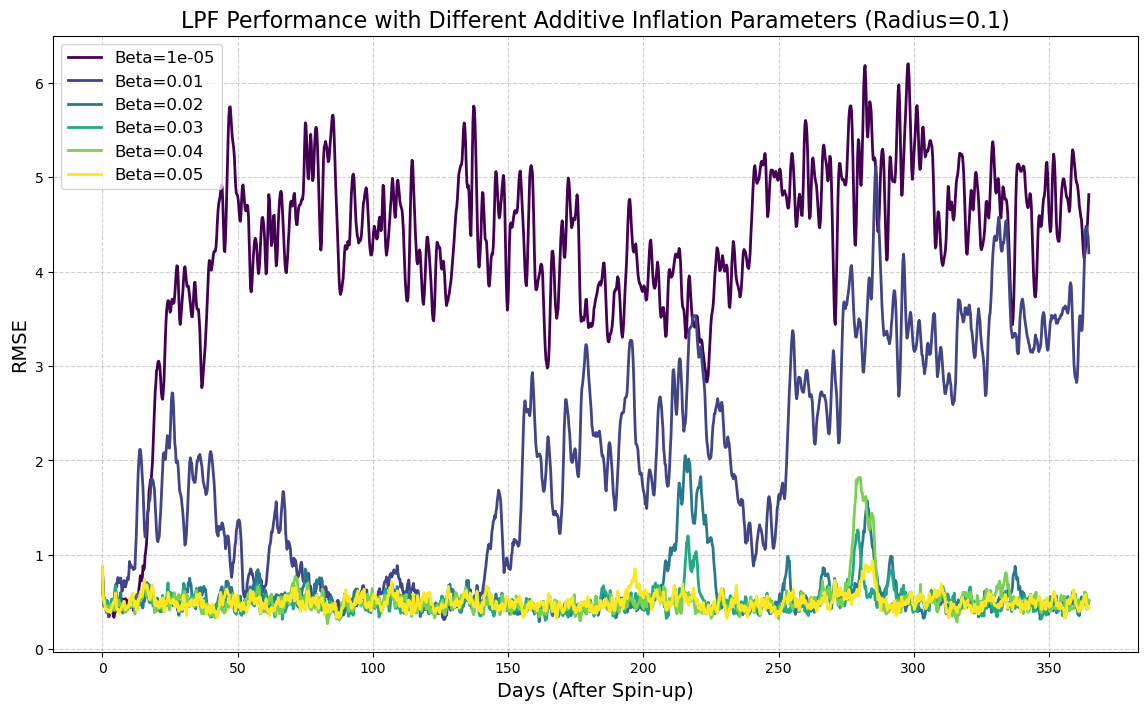

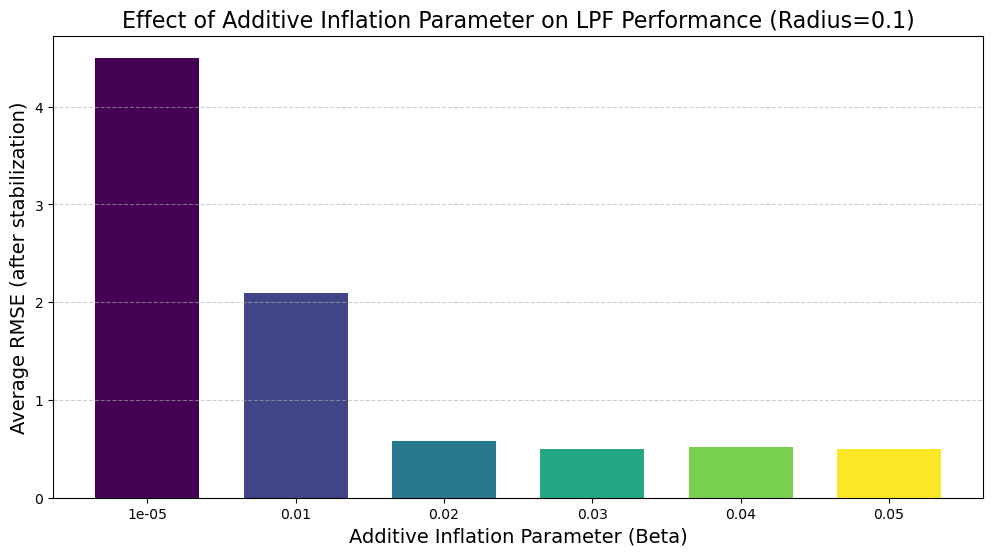

Best additive inflation parameter: 0.03 with average RMSE: 0.500532

Detailed results:
Beta 1e-05: Average RMSE = 4.500977
Beta 0.01: Average RMSE = 2.092912
Beta 0.02: Average RMSE = 0.579341
Beta 0.03: Average RMSE = 0.500532
Beta 0.04: Average RMSE = 0.520169
Beta 0.05: Average RMSE = 0.501319


In [ ]:
# Compare LPF performance with different additive inflation parameters (beta)
fixed_radius = 0.1  # Fixed localization radius based on your previous tests
ensemble_size = 50  # Fixed ensemble size
beta_list = [0.00001, 0.01, 0.02, 0.03, 0.04,  0.05]  # Different beta values to test
rmse_results_beta = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPF with different additive inflation parameters (fixed radius={fixed_radius}, ensemble size={ensemble_size})...")

for beta in beta_list:
    print(f"Running LPF with beta={beta}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this beta value
    for t in range(obs_data.shape[0]):
        x, weights = local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=rk4_step, 
            alpha=0.0,                  # Set alpha to 0 (no RTPS)
            beta=beta,                  # Use the current beta value
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this beta
    rmse_results_beta.append(rmse_values)

# Plot RMSE vs time for different beta values
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(beta_list)))

for i, beta in enumerate(beta_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_beta[i], 
             label=f"Beta={beta}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Additive Inflation Parameters (Radius={fixed_radius})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_beta = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_beta]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(beta_list)), avg_rmse_by_beta, color=colors, width=0.7)
plt.xticks(range(len(beta_list)), [str(b) for b in beta_list])
plt.xlabel("Additive Inflation Parameter (Beta)", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Additive Inflation Parameter on LPF Performance (Radius={fixed_radius})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best beta
best_idx = np.argmin(avg_rmse_by_beta)
print(f"Best additive inflation parameter: {beta_list[best_idx]} with average RMSE: {avg_rmse_by_beta[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, beta in enumerate(beta_list):
    print(f"Beta {beta}: Average RMSE = {avg_rmse_by_beta[i]:.6f}")

Testing LPF with different ensemble sizes...
Running LPF with ensemble size 50
Running LPF with ensemble size 100
Running LPF with ensemble size 200
Running LPF with ensemble size 300


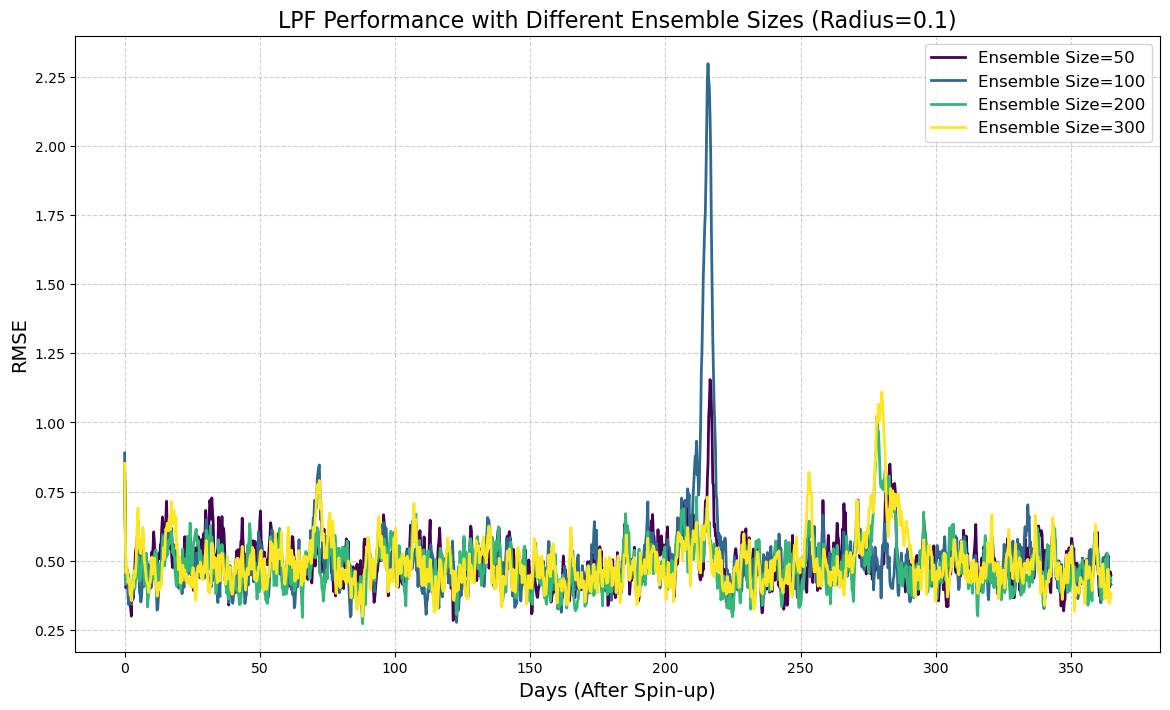

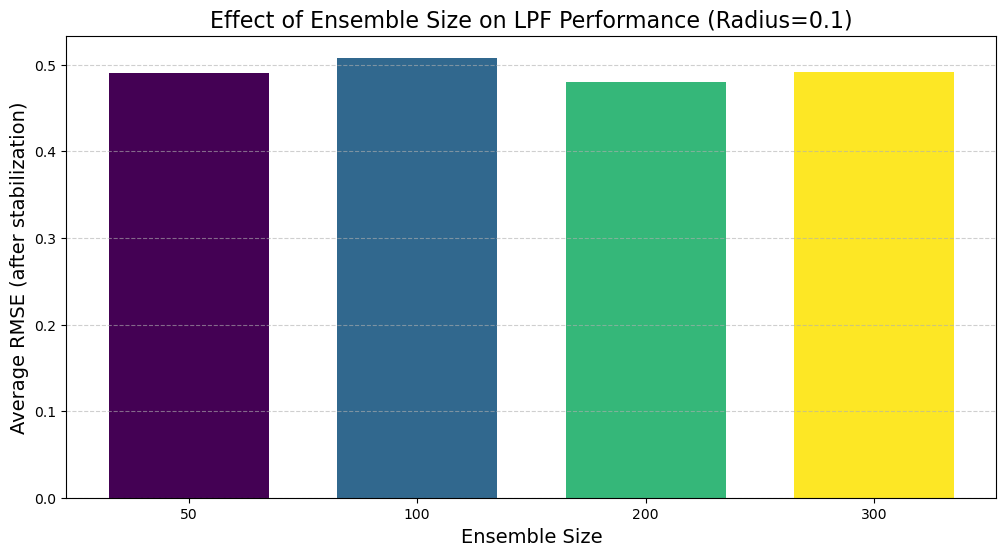

Best ensemble size: 200 with average RMSE: 0.480258

Detailed results:
Ensemble Size 50: Average RMSE = 0.490315
Ensemble Size 100: Average RMSE = 0.508106
Ensemble Size 200: Average RMSE = 0.480258
Ensemble Size 300: Average RMSE = 0.491535


In [ ]:
# Compare LPF performance
# Compare LPF performance with different ensemble sizes
ensemble_sizes = [50, 100, 200,300]  # List of ensemble sizes to test
rmse_results_lpf = []
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance
print(f"Testing LPF with different ensemble sizes...")  
for ens_size in ensemble_sizes:
    print(f"Running LPF with ensemble size {ens_size}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this ensemble size
    for t in range(obs_data.shape[0]):
        x, weights = local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=rk4_step, 
            beta=0.03,
            n_samples=10, 
            Neff_threshold=ens_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this ensemble size
    rmse_results_lpf.append(rmse_values)
# Plot RMSE vs time for different ensemble sizes
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(ensemble_sizes))) 
for i, ens_size in enumerate(ensemble_sizes):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_lpf[i], 
             label=f"Ensemble Size={ens_size}", 
             linewidth=2,
             color=colors[i])
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Ensemble Sizes (Radius={fixed_radius})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_lpf]
# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(ensemble_sizes)), avg_rmse_by_size, color=colors, width=0.7)
plt.xticks(range(len(ensemble_sizes)), [str(s) for s in ensemble_sizes])
plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Ensemble Size on LPF Performance (Radius={fixed_radius})", fontsize=16)       
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()
# Print the best ensemble size
best_idx = np.argmin(avg_rmse_by_size)
print(f"Best ensemble size: {ensemble_sizes[best_idx]} with average RMSE: {avg_rmse_by_size[best_idx]:.6f}")
# Optional: Show detailed table of results
print("\nDetailed results:")
for i, size in enumerate(ensemble_sizes):
    print(f"Ensemble Size {size}: Average RMSE = {avg_rmse_by_size[i]:.6f}")

In [8]:
def local_particle_filter_gaussian_mixture(ensemble, H, R, y, Q, weights=None, loc_radius=5, 
                                          model=rk4_step, alpha=0.0, gamma=1.0, 
                                          n_samples=100, Neff_threshold=None, tau=0.1):
    """
    Local Particle Filter with Gaussian Mixture approximation (LPFGM).
    
    Parameters:
    -----------
    ensemble : np.ndarray
        Shape (Nx, m). Nx = state dimension, m = ensemble size.
    H : np.ndarray
        Observation operator of shape (Ny, Nx).
    R : np.ndarray
        Observation error covariance of shape (Ny, Ny).
    y : np.ndarray
        Observed vector of shape (Ny,).
    Q : np.ndarray
        Process noise covariance of shape (Nx, Nx).
    weights : np.ndarray or None
        Previous weights from last analysis, shape (Nx, m).
        If None, initialize with uniform weights.
    loc_radius : float
        Localization radius (sigma in the Gaussian localization function).
    model : function
        Model propagation function that takes a state vector and returns the next state.
    alpha : float
        RTPS inflation parameter for posterior ensemble spread.
    gamma : float
        Scaling factor for the covariance matrix in Gaussian mixture kernels.
        Larger gamma widens kernels and reduces peak amplitude.
    n_samples : int
        Number of Monte-Carlo samples to generate the transform matrix.
    Neff_threshold : float or None
        Effective ensemble size threshold for resampling.
    tau : float
        Forgetting factor for weight succession (0 ≤ τ ≤ 1).
        
    Returns:
    --------
    updated_ensemble : np.ndarray
        The updated ensemble with shape (Nx, m).
    updated_weights : np.ndarray
        Updated weights with shape (Nx, m).
    """
    Nx, m = ensemble.shape
    Ny = H.shape[0]
    
    # Initialize weights if not provided
    if weights is None:
        weights = np.ones((Nx, m)) / m
    
    # 1) Forecast step
    ens_forecast = np.zeros_like(ensemble)
    for i in range(m):
        ens_forecast[:, i] = model(ensemble[:, i], dt=0.05, F=8)
    
    # 2) Compute forecast mean and anomalies (Z)
    x_bar_f = np.mean(ens_forecast, axis=1)  # shape (Nx,)
    Z = ens_forecast - x_bar_f[:, None]      # shape (Nx, m)
    
    # Calculate forecast spread for inflation later
    spread_f = np.std(ens_forecast, axis=1)  # shape (Nx,)
    
    # 3) Define localization function (Gaussian with cutoff)
    def localization_function(distance, sigma=loc_radius):
        """Gaussian localization function with cutoff"""
        cutoff = 2 * np.sqrt(10.0/3.0) * sigma
        if distance < cutoff:
            return np.exp(-0.5 * (distance**2) / (sigma**2))
        else:
            return 0.0
    
    # 4) Local analysis for each grid point
    updated_ensemble = np.zeros((Nx, m))
    updated_weights = np.zeros((Nx, m))
    
    for i in range(Nx):
        # Build localized R for this grid point
        R_loc = np.diag(np.diag(R).copy())
        for j in range(Ny):
            # Calculate distance with periodic boundary conditions
            dist = min(abs(i - j), Nx - abs(i - j))
            loc_factor = localization_function(dist)
            R_loc[j, j] = (R_loc[j, j] / loc_factor) if loc_factor > 0 else 1.0e10
        
        
        
        # ---------- STEP 1: Kalman update of kernel centers ----------
        
        # Construct scaled local covariance matrix 
        # We compute a simplified version for computational efficiency
        # P_hat = gamma * Z @ Z.T / (m-1)
        Z_loc = Z[i, :].reshape(1, m)  # Local anomalies for grid point i, shape (1, m)
        
        # Project to observation space
        HZ = H @ Z  # shape (Ny, m)
        
        # Compute innovation covariance in ensemble space (ETKF form)
        R_loc_inv = np.linalg.inv(R_loc)
        
        # P_tilde_inv combines the prior ((m-1)/gamma * I) with the observation impact
        P_tilde_inv = np.eye(m) * ((m-1) / gamma) + HZ.T @ R_loc_inv @ HZ
   
        # SVD to find transformation matrix
        U, s, Vt = np.linalg.svd(P_tilde_inv)
        
       # Compute innovation at grid point i
        d = y - H @ x_bar_f  # innovation vector, shape (Ny,)
        T = U @ np.diag(1.0 / s) @ U.T @ HZ.T @ np.linalg.inv(R_loc) @ d + np.eye(m)
        
        
        # Apply Kalman update for kernel centers 
        x_a_i = x_bar_f[i] + Z_loc @ T  # Updated 　vector　shape (1, m)
        
        # ---------- STEP 2: Resampling based on posterior weights ----------
        
        # Compute observation likelihood for each moved particle
        # obs_diff = y[i] - H[i, :] @ x_a_i  # shape (m,)
        obs_diff = y.reshape(-1, 1) - H @ ens_forecast  # shape (Ny,m)

        # Calculate quadratic forms (scaled distances in observation space)
        quad_forms = np.zeros(m)
        for j in range(m):
            quad_forms[j] = obs_diff[:, j].T @ R_loc_inv @ obs_diff[:, j]
        
        # Convert to likelihood weights
        likelihood = np.exp(-0.5 * quad_forms)
        
        # Normalize weights
        posterior_weights = likelihood / np.sum(likelihood)
     
        # Check effective ensemble size with proper posterior weights
        # Neff = 1.0 / np.sum(posterior_weights**2)
                        
        # if Neff_threshold is not None and Neff >= Neff_threshold:
        #     # Skip resampling for this grid point
        #     updated_ensemble[i, :] = X_km  # Keep Kalman-moved particles
            
        #     # Apply weight succession formula
        #     updated_weights[i, :] = (1 - tau) * posterior_weights + tau/m
    
        # Generate transform matrix via Monte-Carlo resampling
        T_q = mc_resampling_matrix(posterior_weights, m, n_samples=n_samples)
        
        
        # Apply transform matrix to grid point 
        updated_ensemble[i, :] = x_a_i @ T_q
        
        # Reset weights to uniform after resampling
        updated_weights[i, :] = np.ones(m) / m
    
    # 5) Apply RTPS inflation if needed
    if alpha > 0.0:
        # Compute analysis mean and perturbations
        x_bar_a = np.mean(updated_ensemble, axis=1)  # shape (Nx,)
        perturbations_a = updated_ensemble - x_bar_a[:, None]  # shape (Nx, m)
        
        # Compute analysis spread
        spread_a = np.std(updated_ensemble, axis=1)  # shape (Nx,)
        
        # Apply RTPS formula for each state variable
        for k in range(Nx):
            # Avoid division by zero
            if spread_a[k] > 1e-10:
                rtps_factor = (1.0 - alpha) + alpha * (spread_f[k] / spread_a[k])
                perturbations_a[k, :] *= rtps_factor
        
        # Reconstruct ensemble
        updated_ensemble = x_bar_a[:, None] + perturbations_a
    
    return updated_ensemble, updated_weights

In [16]:
def local_particle_filter_gaussian_mixture(ensemble, H, R, y, Q, weights=None, loc_radius=5, 
                                          model=rk4_step, alpha=0.0, gamma=1.0, 
                                          n_samples=100, Neff_threshold=None, tau=0.1):
    # ...existing code...
    Nx, m = ensemble.shape
    Ny = H.shape[0]

    if weights is None:
        weights = np.ones((Nx, m)) / m
    
    ens_forecast = np.zeros_like(ensemble)
    for i in range(m):
        ens_forecast[:, i] = model(ensemble[:, i], dt=0.05, F=8)
    
    x_bar_f = np.mean(ens_forecast, axis=1)
    Z = ens_forecast - x_bar_f[:, None]
    spread_f = np.std(ens_forecast, axis=1)
    
    def localization_function(distance, sigma=loc_radius):
        cutoff = 2 * np.sqrt(10.0/3.0) * sigma
        return np.exp(-0.5 * (distance**2) / (sigma**2)) if distance < cutoff else 0.0
    
    # --- Step 1: Compute kernel centers (Kalman update) for each grid point ---
    x_a_array = np.zeros((Nx, m))
    R_loc_list = []
    T_list = []

    for i in range(Nx):
        R_loc = np.diag(np.diag(R).copy())
        for j in range(Ny):
            dist = min(abs(i - j), Nx - abs(i - j))
            loc_factor = localization_function(dist)
            R_loc[j, j] = (R_loc[j, j] / loc_factor) if loc_factor > 0 else 1.0e10
        
        R_loc_inv = np.linalg.inv(R_loc)
        HZ = H @ Z
        P_tilde_inv = np.eye(m) * ((m-1) / gamma) + HZ.T @ R_loc_inv @ HZ

        U, s, Vt = np.linalg.svd(P_tilde_inv)
        d = y - H @ x_bar_f
        T = U @ np.diag(1.0 / s) @ U.T @ HZ.T @ R_loc_inv @ d + np.eye(m)

        # Store T for potential diagnostic or extension
        T_list.append(T)
        R_loc_list.append(R_loc_inv)
        
        x_a_i = x_bar_f[i] + Z[i, :].reshape(1, m) @ T
        x_a_array[i, :] = x_a_i
    
    # --- Step 2: Resampling using x_a_array from Step 1 ---
    updated_ensemble = np.zeros((Nx, m))
    updated_weights = np.zeros((Nx, m))

    obs_diff_full = y.reshape(-1, 1) - H @ x_a_array  # Use updated centers for likelihood

    for i in range(Nx):
        R_loc_inv = R_loc_list[i]
        quad_forms = np.zeros(m)
        for j in range(m):
            quad_forms[j] = obs_diff_full[:, j].T @ R_loc_inv @ obs_diff_full[:, j]
        
        likelihood = np.exp(-0.5 * quad_forms)
        posterior_weights = likelihood / np.sum(likelihood)

        T_q = mc_resampling_matrix(posterior_weights, m, n_samples=n_samples)
        updated_ensemble[i, :] = x_a_array[i, :].reshape(1, m) @ T_q
        updated_weights[i, :] = np.ones(m) / m
    
    # RTPS inflation
    if alpha > 0.0:
        x_bar_a = np.mean(updated_ensemble, axis=1)
        perturbations_a = updated_ensemble - x_bar_a[:, None]
        spread_a = np.std(updated_ensemble, axis=1)
        for k in range(Nx):
            if spread_a[k] > 1e-10:
                rtps_factor = (1.0 - alpha) + alpha * (spread_f[k] / spread_a[k])
                perturbations_a[k, :] *= rtps_factor
        updated_ensemble = x_bar_a[:, None] + perturbations_a

    return updated_ensemble, updated_weights


In [23]:
# Compare LPFGM performance with different gamma parameters
fixed_radius = 1 # Fixed localization radius based on previous tests
ensemble_size = 10  # Fixed ensemble size
gamma_list = [2.5]
# gamma_list = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0]  # Different gamma values to test
rmse_results_gamma = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPFGM with different gamma parameters (fixed radius={fixed_radius}, ensemble size={ensemble_size})...")

for gamma in gamma_list:
    print(f"Running LPFGM with gamma={gamma}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPFGM loop for this gamma value
    for t in range(obs_data.shape[0]):
        x, weights = local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=rk4_step, 
            alpha=0.6,  # No RTPS inflation
            gamma=gamma,  # Current gamma value being tested
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this gamma
    rmse_results_gamma.append(rmse_values)

# Plot RMSE vs time for different gamma values
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_list)))

for i, gamma in enumerate(gamma_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_gamma[i], 
             label=f"Gamma={gamma}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPFGM Performance with Different Gamma Parameters (Radius={fixed_radius})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_gamma = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_gamma]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(gamma_list)), avg_rmse_by_gamma, color=colors, width=0.7)
plt.xticks(range(len(gamma_list)), [str(g) for g in gamma_list])
plt.xlabel("Gamma Parameter", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Gamma Parameter on LPFGM Performance (Radius={fixed_radius})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best gamma
best_idx = np.argmin(avg_rmse_by_gamma)
print(f"Best gamma parameter: {gamma_list[best_idx]} with average RMSE: {avg_rmse_by_gamma[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, gamma in enumerate(gamma_list):
    print(f"Gamma {gamma}: Average RMSE = {avg_rmse_by_gamma[i]:.6f}")

Testing LPFGM with different gamma parameters (fixed radius=1, ensemble size=10)...
Running LPFGM with gamma=2.5


KeyboardInterrupt: 

In [ ]:
# Compare LPF performance with different localization radii
ensemble_size = 100  # Fixed ensemble size
radius_list = [0.5,1]  # Different radii to test
rmse_results_radius = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPF with different localization radii (ensemble size={ensemble_size})...")

for radius in radius_list:
    print(f"Running LPF with radius={radius}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this radius
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=radius,
            model=f.rk4_step, 
            alpha=0.7,
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this radius
    rmse_results_radius.append(rmse_values)

# Plot RMSE vs time for different radii
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(radius_list)))

for i, radius in enumerate(radius_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_radius[i], 
             label=f"Radius={radius}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Localization Radii (Ensemble Size={ensemble_size})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_radius = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_radius]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(radius_list)), avg_rmse_by_radius, color=colors, width=0.7)
plt.xticks(range(len(radius_list)), [str(r) for r in radius_list])
plt.xlabel("Localization Radius", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Localization Radius on LPF Performance (Ensemble Size={ensemble_size})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best radius
best_idx = np.argmin(avg_rmse_by_radius)
print(f"Best localization radius: {radius_list[best_idx]} with average RMSE: {avg_rmse_by_radius[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, radius in enumerate(radius_list):
    print(f"Radius {radius}: Average RMSE = {avg_rmse_by_radius[i]:.6f}")

In [ ]:
# Compare LPF performance with different inflation parameters (alpha)
fixed_radius = 0.1  # Fixed localization radius
ensemble_size = 100  # Fixed ensemble size
alpha_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Different alpha values to test
rmse_results_alpha = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPF with different inflation parameters (fixed radius={fixed_radius}, ensemble size={ensemble_size})...")

for alpha in alpha_list:
    print(f"Running LPF with alpha={alpha}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this alpha value
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=f.rk4_step, 
            alpha=alpha,
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this alpha
    rmse_results_alpha.append(rmse_values)

# Plot RMSE vs time for different alpha values
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(alpha_list)))

for i, alpha in enumerate(alpha_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_alpha[i], 
             label=f"Alpha={alpha}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Inflation Parameters (Radius={fixed_radius}, Ensemble Size={ensemble_size})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_alpha = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_alpha]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(alpha_list)), avg_rmse_by_alpha, color=colors, width=0.7)
plt.xticks(range(len(alpha_list)), [str(a) for a in alpha_list])
plt.xlabel("Inflation Parameter (Alpha)", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Inflation Parameter on LPF Performance (Radius={fixed_radius})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best alpha
best_idx = np.argmin(avg_rmse_by_alpha)
print(f"Best inflation parameter: {alpha_list[best_idx]} with average RMSE: {avg_rmse_by_alpha[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, alpha in enumerate(alpha_list):
    print(f"Alpha {alpha}: Average RMSE = {avg_rmse_by_alpha[i]:.6f}")
    

In [ ]:
# Compare LPF performance with different additive inflation parameters (beta)
fixed_radius = 0.1  # Fixed localization radius based on your previous tests
ensemble_size = 50  # Fixed ensemble size
beta_list = [0.00001, 0.01, 0.02, 0.03, 0.04,  0.05]  # Different beta values to test
rmse_results_beta = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPF with different additive inflation parameters (fixed radius={fixed_radius}, ensemble size={ensemble_size})...")

for beta in beta_list:
    print(f"Running LPF with beta={beta}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this beta value
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=f.rk4_step, 
            alpha=0.0,                  # Set alpha to 0 (no RTPS)
            beta=beta,                  # Use the current beta value
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this beta
    rmse_results_beta.append(rmse_values)

# Plot RMSE vs time for different beta values
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(beta_list)))

for i, beta in enumerate(beta_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_beta[i], 
             label=f"Beta={beta}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Additive Inflation Parameters (Radius={fixed_radius})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_beta = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_beta]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(beta_list)), avg_rmse_by_beta, color=colors, width=0.7)
plt.xticks(range(len(beta_list)), [str(b) for b in beta_list])
plt.xlabel("Additive Inflation Parameter (Beta)", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Additive Inflation Parameter on LPF Performance (Radius={fixed_radius})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best beta
best_idx = np.argmin(avg_rmse_by_beta)
print(f"Best additive inflation parameter: {beta_list[best_idx]} with average RMSE: {avg_rmse_by_beta[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, beta in enumerate(beta_list):
    print(f"Beta {beta}: Average RMSE = {avg_rmse_by_beta[i]:.6f}")

In [ ]:
# Compare LPF performance
# Compare LPF performance with different ensemble sizes
ensemble_sizes = [50, 100, 200,300]  # List of ensemble sizes to test
rmse_results_lpf = []
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance
print(f"Testing LPF with different ensemble sizes...")  
for ens_size in ensemble_sizes:
    print(f"Running LPF with ensemble size {ens_size}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPF loop for this ensemble size
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model= f.rk4_step, 
            beta=0.03,
            n_samples=10, 
            Neff_threshold=ens_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this ensemble size
    rmse_results_lpf.append(rmse_values)
# Plot RMSE vs time for different ensemble sizes
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(ensemble_sizes))) 
for i, ens_size in enumerate(ensemble_sizes):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_lpf[i], 
             label=f"Ensemble Size={ens_size}", 
             linewidth=2,
             color=colors[i])
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPF Performance with Different Ensemble Sizes (Radius={fixed_radius})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_lpf]
# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(ensemble_sizes)), avg_rmse_by_size, color=colors, width=0.7)
plt.xticks(range(len(ensemble_sizes)), [str(s) for s in ensemble_sizes])
plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Ensemble Size on LPF Performance (Radius={fixed_radius})", fontsize=16)       
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()
# Print the best ensemble size
best_idx = np.argmin(avg_rmse_by_size)
print(f"Best ensemble size: {ensemble_sizes[best_idx]} with average RMSE: {avg_rmse_by_size[best_idx]:.6f}")
# Optional: Show detailed table of results
print("\nDetailed results:")
for i, size in enumerate(ensemble_sizes):
    print(f"Ensemble Size {size}: Average RMSE = {avg_rmse_by_size[i]:.6f}")

In [ ]:
# Compare LPFGM performance with different gamma parameters
fixed_radius = 0.5 # Fixed localization radius based on previous tests
ensemble_size = 150  # Fixed ensemble size
# gamma_list = [1.5,2.5,3.5]
gamma_list = [0.5, 1.5, 2.5, 3.5]  # Different gamma values to test
rmse_results_gamma = []

H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance

print(f"Testing LPFGM with different gamma parameters (fixed radius={fixed_radius}, ensemble size={ensemble_size})...")

for gamma in gamma_list:
    print(f"Running LPFGM with gamma={gamma}")
    
    # Reset initial ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None  # Initialize weights to None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    # LPFGM loop for this gamma value
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights, 
            loc_radius=fixed_radius,
            model=f.rk4_step, 
            alpha=0.8,  # No RTPS inflation
            gamma=gamma,  # Current gamma value being tested
            n_samples=10, 
            Neff_threshold=ensemble_size/2,  # Set threshold as half the ensemble size
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    # Store RMSE results for this gamma
    rmse_results_gamma.append(rmse_values)

# Plot RMSE vs time for different gamma values
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_list)))

for i, gamma in enumerate(gamma_list):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_gamma[i], 
             label=f"Gamma={gamma}", 
             linewidth=2,
             color=colors[i])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title(f"LPFGM Performance with Different Gamma Parameters (Radius={fixed_radius})", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_gamma = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_gamma]

# Bar plot for average RMSE comparison
plt.figure(figsize=(12, 6))
plt.bar(range(len(gamma_list)), avg_rmse_by_gamma, color=colors, width=0.7)
plt.xticks(range(len(gamma_list)), [str(g) for g in gamma_list])
plt.xlabel("Gamma Parameter", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title(f"Effect of Gamma Parameter on LPFGM Performance (Radius={fixed_radius})", fontsize=16)
plt.grid(True, linestyle='--', axis='y', alpha=0.6)
plt.show()

# Print the best gamma
best_idx = np.argmin(avg_rmse_by_gamma)
print(f"Best gamma parameter: {gamma_list[best_idx]} with average RMSE: {avg_rmse_by_gamma[best_idx]:.6f}")

# Optional: Show detailed table of results
print("\nDetailed results:")
for i, gamma in enumerate(gamma_list):
    print(f"Gamma {gamma}: Average RMSE = {avg_rmse_by_gamma[i]:.6f}")

In [ ]:
# Compare LPFGM performance with different localization radii
fixed_gamma = 2.5
radius_list = [0.1]  # Add more values if desired
ensemble_size = 50
rmse_results_radius = []

H = np.eye(N)
R = np.eye(N)
Q = np.eye(N) * 0

for radius in radius_list:
    # Reset ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None

    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])

    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights,
            loc_radius=radius,
            model=f.rk4_step,
            alpha=0.6,
            gamma=fixed_gamma,
            n_samples=10,
            Neff_threshold=ensemble_size/2,
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])

    rmse_results_radius.append(rmse_values)

# Plot results
plt.figure(figsize=(10, 6))
for i, radius in enumerate(radius_list):
    plt.plot(rmse_results_radius[i], label=f"Radius={radius}")
plt.xlabel("Time Step")
plt.ylabel("RMSE")
plt.title("LPFGM Performance with Different Localization Radii")
plt.legend()
plt.grid(True)
plt.show()

# Compare averages after spin-up
spinup_steps = 50
avg_rmse = [np.mean(rmse[spinup_steps:]) for rmse in rmse_results_radius]
for radius, val in zip(radius_list, avg_rmse):
    print(f"Radius={radius}, Average RMSE={val:.4f}")

In [ ]:
# Compare LPFGM performance with different alpha parameters (fixed gamma and radius)
fixed_gamma = 2.5
fixed_radius = 0.5
alpha_list = [0.5,0.6,0.7,0.8]
ensemble_size = 150
rmse_results_alpha = []

H = np.eye(N)
R = np.eye(N)
Q = np.eye(N) * 0

print(f"Testing LPFGM with different alpha values (gamma={fixed_gamma}, radius={fixed_radius})...")

for alpha in alpha_list:
    print(f"Running LPFGM with alpha={alpha}")
    
    # Reset ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights,
            loc_radius=fixed_radius,
            model=f.rk4_step,
            alpha=alpha,
            gamma=fixed_gamma,
            n_samples=10,
            Neff_threshold=ensemble_size/2,
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    rmse_results_alpha.append(rmse_values)

# Plot RMSE vs time for different alpha values
plt.figure(figsize=(10, 6))
for i, alpha in enumerate(alpha_list):
    plt.plot(rmse_results_alpha[i], label=f"Alpha={alpha}")
plt.xlabel("Time Step")
plt.ylabel("RMSE")
plt.title(f"LPFGM with Various Alpha Values (Gamma={fixed_gamma}, Radius={fixed_radius})")
plt.legend()
plt.grid(True)
plt.show()

# Compare average RMSE after spin-up
spinup_steps = 50
avg_rmse_by_alpha = [np.mean(rmse[spinup_steps:]) for rmse in rmse_results_alpha]
for alpha, val in zip(alpha_list, avg_rmse_by_alpha):
    print(f"Alpha={alpha}, Average RMSE={val:.4f}")


In [ ]:
# Compare LPFGM performance with different alpha parameters (fixed gamma and radius)
fixed_gamma = 2.5
fixed_radius = 0.5
alpha_list = [0.8,0.9]
ensemble_size = 150
rmse_results_alpha = []

H = np.eye(N)
R = np.eye(N)
Q = np.eye(N) * 0

print(f"Testing LPFGM with different alpha values (gamma={fixed_gamma}, radius={fixed_radius})...")

for alpha in alpha_list:
    print(f"Running LPFGM with alpha={alpha}")
    
    # Reset ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights,
            loc_radius=fixed_radius,
            model=f.rk4_step,
            alpha=alpha,
            gamma=fixed_gamma,
            n_samples=10,
            Neff_threshold=ensemble_size/2,
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    rmse_results_alpha.append(rmse_values)

# Plot RMSE vs time for different alpha values
plt.figure(figsize=(10, 6))
for i, alpha in enumerate(alpha_list):
    plt.plot(rmse_results_alpha[i], label=f"Alpha={alpha}")
plt.xlabel("Time Step")
plt.ylabel("RMSE")
plt.title(f"LPFGM with Various Alpha Values (Gamma={fixed_gamma}, Radius={fixed_radius})")
plt.legend()
plt.grid(True)
plt.show()

# Compare average RMSE after spin-up
spinup_steps = 50
avg_rmse_by_alpha = [np.mean(rmse[spinup_steps:]) for rmse in rmse_results_alpha]
for alpha, val in zip(alpha_list, avg_rmse_by_alpha):
    print(f"Alpha={alpha}, Average RMSE={val:.4f}")


In [ ]:
# Parameters
m = 150
loc_radius = 0.5
gamma = 2.5
alpha = 0.8
steps_to_assimilate = obs_data.shape[0]

Q = np.eye(N) * 0
R = np.eye(N)
H = np.eye(N)

# Initialize ensemble
P = np.eye(N) * 1.0
x = np.random.multivariate_normal(stored_data[0], P, size=m).T
weights = None

analysis_mean = np.zeros((steps_to_assimilate, N))
rmse_vals = np.zeros(steps_to_assimilate)

# Single-run LPFGM
for t in range(steps_to_assimilate):
    x, weights = f.local_particle_filter_gaussian_mixture(
        x, H, R, obs_data[t], Q,
        weights=weights,
        loc_radius=loc_radius,
        model=f.rk4_step,
        alpha=alpha,
        gamma=gamma,
        n_samples=10,
        Neff_threshold=m/2,
        tau=0.1
    )
    analysis_mean[t] = np.mean(x, axis=1)
    rmse_vals[t] = f.rmse(stored_data[t], analysis_mean[t])

# Plot RMSE
plt.figure(figsize=(8,4))
days_axis = np.arange(steps_to_assimilate) / 4.0
plt.plot(days_axis, rmse_vals, marker='o', linewidth=2, label="RMSE")
plt.xlabel("Days")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Parameters
m = 150
loc_radius = 0.5
gamma = 2.5
alpha = 0.8
steps_to_assimilate = obs_data.shape[0]

Q = np.eye(N) * 0
R = np.eye(N)
H = np.eye(N)

# Initialize ensemble
P = np.eye(N) * 1.0
x = np.random.multivariate_normal(stored_data[0], P, size=m).T
weights = None

analysis_mean = np.zeros((steps_to_assimilate, N))
rmse_vals = np.zeros(steps_to_assimilate)

# Single-run LPFGM
for t in range(steps_to_assimilate):
    x, weights = f.local_particle_filter_gaussian_mixture2(
        x, H, R, obs_data[t], Q,
        weights=weights,
        loc_radius=loc_radius,
        model=f.rk4_step,
        alpha=alpha,
        gamma=gamma,
        n_samples=10,
        Neff_threshold=m/2,
        tau=0.1
    )
    analysis_mean[t] = np.mean(x, axis=1)
    rmse_vals[t] = f.rmse(stored_data[t], analysis_mean[t])

# Plot RMSE
plt.figure(figsize=(8,4))
days_axis = np.arange(steps_to_assimilate) / 4.0
plt.plot(days_axis, rmse_vals, marker='o', linewidth=2, label="RMSE")
plt.xlabel("Days")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Parameters
m = 100
loc_radius = 0.5
gamma = 2.5
alpha = 0.8
steps_to_assimilate = obs_data.shape[0]

Q = np.eye(N) * 0
R = np.eye(N)
H = np.eye(N)

# Initialize ensemble
P = np.eye(N) * 1.0
x = np.random.multivariate_normal(stored_data[0], P, size=m).T
weights = None

analysis_mean = np.zeros((steps_to_assimilate, N))
rmse_vals = np.zeros(steps_to_assimilate)

# Single-run LPFGM
for t in range(steps_to_assimilate):
    x, weights = f.local_particle_filter_gaussian_mixture(
        x, H, R, obs_data[t], Q,
        weights=weights,
        loc_radius=loc_radius,
        model=f.rk4_step,
        alpha=alpha,
        gamma=gamma,
        n_samples=10,
        Neff_threshold=m/2,
        tau=0.1
    )
    analysis_mean[t] = np.mean(x, axis=1)
    rmse_vals[t] = f.rmse(stored_data[t], analysis_mean[t])

# Plot RMSE
plt.figure(figsize=(8,4))
days_axis = np.arange(steps_to_assimilate) / 4.0
plt.plot(days_axis, rmse_vals, marker='o', linewidth=2, label="RMSE")
plt.xlabel("Days")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Parameters
m = 100
loc_radius = 0.5
gamma = 2.5
alpha = 0.8
steps_to_assimilate = obs_data.shape[0]

Q = np.eye(N) * 0
R = np.eye(N)
H = np.eye(N)

# Initialize ensemble
P = np.eye(N) * 1.0
x = np.random.multivariate_normal(stored_data[0], P, size=m).T
weights = None

analysis_mean = np.zeros((steps_to_assimilate, N))
rmse_vals = np.zeros(steps_to_assimilate)

# Single-run LPFGM
for t in range(steps_to_assimilate):
    x, weights = f.local_particle_filter_gaussian_mixture2(
        x, H, R, obs_data[t], Q,
        weights=weights,
        loc_radius=loc_radius,
        model=f.rk4_step,
        alpha=alpha,
        gamma=gamma,
        n_samples=10,
        Neff_threshold=m/2,
        tau=0.1
    )
    analysis_mean[t] = np.mean(x, axis=1)
    rmse_vals[t] = f.rmse(stored_data[t], analysis_mean[t])

# Plot RMSE
plt.figure(figsize=(8,4))
days_axis = np.arange(steps_to_assimilate) / 4.0
plt.plot(days_axis, rmse_vals, marker='o', linewidth=2, label="RMSE")
plt.xlabel("Days")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# -------------------------------------------
# LPF Parameter Sweep: alpha, beta, radius
# -------------------------------------------

alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.02, 0.04, 0.06, 0.08]
radius_list = [0.0, 0.3, 0.6 ,0.9, 1.2]
ensemble_size = 100
steps_to_assimilate = obs_data.shape[0]
spinup_steps = 50  # Steps to disregard before averaging RMSE

lpf_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPF with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta,
                        n_samples=10, Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpf_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpf_results[i, j, k] = np.nan


# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.viridis.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpf_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=1)
    
    ax.set_title(f"LPF (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPF RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


In [ ]:
# --------------------------------------------
# LPFGM Parameter Sweep: alpha, gamma, radius
# --------------------------------------------
alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.02, 0.04, 0.06, 0.08]
radius_list = [0.01, 0.3, 0.6 ,0.9, 1.2]
gamma = 4
ensemble_size = 100

lpfgm_results = np.zeros((len(alpha_list), len(gamma_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPFGM with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter_gaussian_mixture(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta, gamma=gamma, n_samples=10,
                        Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpfgm_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, gamma={gamma}, radius={radius}. Error: {e}")
                lpfgm_results[i, j, k] = np.nan


# 2D heatmaps: for each radius, show alpha vs gamma
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)
for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpfgm_results[:, :, idx]
    c = ax.imshow(data_2d, origin='lower', cmap='viridis',
                  extent=[0, len(gamma_list), 0, len(alpha_list)],
                  aspect='auto')
    ax.set_title(f"LPFGM (radius={radius})")
    ax.set_xticks(np.arange(len(gamma_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(gamma_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("gamma")
    if idx == 0:
        ax.set_ylabel("alpha")
    fig.colorbar(c, ax=ax)
plt.suptitle("LPFGM RMSE Heatmaps (alpha vs gamma, each plot = different radius)")
plt.tight_layout()
plt.show()

In [ ]:
# Compare LPFGM performance with different gamma parameters (fixed alpha and beta, radius)
fixed_radius = 0.5
alpha = 0.8
beta = 0
gamma_list = [0.1,0.2,0.3,0.4,0.5, 1.5, 2.5, 3.5, 4, 4.5 ,5, 5.5 ]  # Different gamma values to test
ensemble_size = 50
rmse_results_gamma = []

H = np.eye(N)
R = np.eye(N)
Q = np.eye(N) * 0

print(f"Testing LPFGM with different gamma values (alpha={alpha}, radius={fixed_radius})...")

for gamma in gamma_list:
    print(f"Running LPFGM with gamma={gamma}")
    
    # Reset ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights,
            loc_radius=fixed_radius,
            model=f.rk4_step,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_samples=10,
            Neff_threshold=ensemble_size/2,
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    rmse_results_gamma.append(rmse_values)

# Plot RMSE vs time for different gamma values
plt.figure(figsize=(10, 6))
for i, gamma in enumerate(gamma_list):
    plt.plot(rmse_results_gamma[i], label=f"Gamma={gamma}")
plt.xlabel("Time Step")
plt.ylabel("RMSE")
plt.title(f"LPFGM with Various Gamma Values (Alpha={alpha}, Radius={fixed_radius})")
plt.legend()
plt.grid(True)
plt.show()

# Compare average RMSE after spin-up
spinup_steps = 50
avg_rmse_by_gamma = [np.mean(rmse[spinup_steps:]) for rmse in rmse_results_gamma]
for gamma, val in zip(gamma_list, avg_rmse_by_gamma):
    print(f"Gamma={gamma}, Average RMSE={val:.4f}")

